# Assignment 4 - Time-dependent problems

This notebook will be focused on solving time-dependent problems using computational techniques. Consider a square plate with sides $[-1,1] \times [-1,1]$. At time $t = 0$ we are heating the plate up such that the temperature is $u = 5$ on one side and $u = 0$ on the other sides. The temperature evolves according to $u_t = \Delta u$. I will first find what time $t^*$ the plate reaches $u = 1$ at the center of the plate by implementing a finite difference scheme with explicit and implicit time-stepping. The stability of these schemes will be investigated numerically and by increasing the number of discretisation points I will estimate the maximum accuracy that can be achieved. I will plot the convergence of the computed time againsst the actual time $t^* = 0.424011387033$. A gpu version of the explicit time-stepping scheme will also be implemented.

## Introduction to Finite Difference Time Stepping Techniques

The finite difference method is used to discretise PDE's so they can be solved numerically. In this assignment we will be solving the equation for the propogation of heat in 2D which fits the form of a second order linear PDE. We can represent the equation we are trying to solve below:

$$
\frac{\partial^2u(x)}{\partial x^2} + \frac{\partial^2u(y)}{\partial y^2} = \frac{\partial u(t)}{\partial t}
$$

We will begin with the taylor expansions of the forward and backward steps:
$$
u(x + \Delta x) = u(x) + u'(x) \Delta x + \frac{1}{2} u''(x)(\Delta x)^2 + ...
$$
$$
u(x - \Delta x) = u(x) - u'(x) \Delta x + \frac{1}{2} u''(x)(\Delta x)^2 + ...
$$

These can be added to obtain the three-point stencil in time and space center difference formula.
$$
u''(x) = \frac{u(x+\Delta x) + u(x - \Delta x) - 2u(x)}{\Delta x^2}
$$

To find the back and forward propogation formulas we can use the taylor expansion and neglect orders above 2 we can rearrange to get the equations shown below. The back propogation formulae will be shown first with the forward propogation formulae shown next.


$$
u'(x) = \frac{u(x) - u(x - \Delta x)}{\Delta x} = 
\frac{u(x + \Delta x) + u(x - \Delta x) + u(y + \Delta y) + u(y - \Delta y) - 4u(x,y)}{\partial \Delta x^2}
$$

$$
u'(x) = \frac{u(x + \Delta x) - u(x)}{\Delta x} = \frac{u(x + \Delta ) + u(x - \Delta x) + u(y + \Delta y) + u(y - \Delta y) - 4(x,y)}{\partial x^2}
$$

These two expressions can be converted to iterative form as shown below for implicit timestepping

$$
u_t(i,j) = -\frac{\Delta t}{\Delta x^2}[u_{t+1}(i+1,j) + u_{t+1}(i-1,j) + u_{t+1}(i,j+1) + u_{t+1}(i,j-1) + 4 u_{t+1}(i,j) ] + u_{t+1}(i,j)
$$

which can be expressed as $(I - \Delta t \alpha)u_{t+1}$ or for explicit timestepping

$$
u_{t+1}(i,j) = \frac{\Delta t}{\Delta x^2}[u_t(i+1,j) + u_t(i-1,j) + u_t(i,j+1) + u_t(i,j-1) - 4 u_t(i,j)] + u_t(i,j)
$$

which can be expressed as $u_{t+1}(i,j) = (1 + \Delta t \alpha)u_t$. It should be noted that $\alpha$ is the laplacian operator $\Delta_{x,y}$. The quantity $\frac{\Delta t}{\Delta x^2}$ can be referred to as the courant number $C$.

## Explicit Time Stepping

I will first apply the euler forwards explicit time stepping method which can be simplified to $u_{t+1}(i,j) = (1 + \Delta t \alpha)u_t$. For this method to be stable the largest magnitude eigenvalue must have a magnitude that is smaller than $\frac{\Delta t}{2}$ leading to the inequality $\Delta t < \frac{2}{|\lambda|}$. For linear stability eigenvalues must also be negative.

I will first define the grid that will be used. If the number of discretisation points is N and the grid dimensions are $[-1,1] \times [-1,1]$ then the width of the plate is 2. Therefore the size of a distance step $\Delta x$ is $\frac{2}{N-1}$. The size of a timestep must satisfy $\Delta t \le \frac{\Delta x^2}{2}$ for stability in a 1D so it can be set to $\Delta t \le \frac{\Delta x^2}{4}$ for a 2D environment. The coefficient $\frac{\Delta t}{\Delta x^2}$ can as a result be assigned the value 1/4 as this problem regards a 2D space. I will initialise a three dimensional grid with two of the dimensions representing the space of the 2D plate and the third represents the time evolution of the system. The center point of the plate can be found at discretisation coodinates $(\frac{N+1}{2},\frac{N+1}{2})$.

#### CPU Numba accelerated approach:

Below I will implement this time stepping regime using numba JIT compilation on the CPU.

In [75]:
from numba import prange, njit,jit,cuda
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, cm
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import numba
from tqdm import tqdm
%matplotlib inline

In [3]:
@njit(parallel=True)
def iterate_dt(u,N,timestep,C):
    """
    Worker function that uses no python fron end of numba CPU JIT compilation. Applies iterative equation to every element in 2D plate matrix.
    Inputs:
        u: previous timestep slice of plate.
        N: Number of discretisation points in plate.
        C: Courant number.
    Outputs:
        u: next timestep slice of plate with heat propogated.
    """
    for i in prange(1,N-1):
        for j in range(1,N-1):
            u[timestep + 1,i,j] = C * (u[timestep,i+1,j] + u[timestep,i - 1,j] + u[timestep,i,j+1] +
                                        u[timestep,i,j-1] - 4 * u[timestep,i,j]) + u[timestep,i,j]
    return u
def forward_euler_cpu(N, max_time = 0.45,C = 0.25,timesteps = None):
    """
    This function applies the forward euler method to find the time taken for heat to propogate across the plate. 
    This version stores every timestep of the plate's heat so is extremely memory intensive to an unnecessary degree.
    Inputs:
        N: Number of discretisation points.
        max_time (optional - default 0.45): Maximum time that the forward euler method iterates to.
        C (optional - default 0.25): Courant number.
        timesteps (optional - default None): Optional input of number of timesteps. If remains None it is calculated.
    Outputs:
        u: Final slice of plate showing final heat propogation stage at max_time.
        central_temps: An array of the central temperature at each timestep.
        counter: The recorded time at which the central temperature reached 1.
    """
    assert N%2 != 0,"For there to be a central discretisation point the number of points N must be odd. Please input an odd number." 
    #check if number is odd or even
    dx = 2/(N-1)
    dt = C * dx**2 
    if timesteps == None:
        timesteps = int(max_time/dt)
    u = np.zeros((timesteps,N,N))
    u[:,(N-1),:] = 5
    counter = 0
    central_temps = np.empty(timesteps)
    for i in range(timesteps-1):
        u = iterate_dt(u,N,i,C)
        central_temp = u[i,int((N+1)/2) - 1,int((N+1)/2) - 1]
        central_temps[i] = central_temp
        if central_temp < 1:
            counter += dt
    central_temps[-1] = u[-1,int((N+1)/2) - 1,int((N+1)/2) - 1]
    return u, central_temps,counter
def time_central_val(sizes,max_time = 0.5,func = forward_euler_cpu):
    """
    This function applies the euler method timestepping technique on the initial plate across a variety of N discretisation point values.
    Inputs:
        sizes: list of sizes that the euler method function are applied over.
        max_time (optional - default 0.45): Maximum time that the forward euler method iterates to.
        func (optional - default forward_euler_cpu): The timestepping function that is being evaluated.
    Outputs:
        times: A list of times it took for the central temperature to reach 1 for each size of N.
        central_temps: A 2D list containing the central temperature of the plate at every timestep for every value of N.
    """
    times = []
    central_temps = []
    for i in tqdm(sizes):
        _,central_temp,timer = func(i,max_time = max_time)
        _ = 0
        times.append(timer)
        central_temps.append(central_temp)
    return times, central_temps

In [3]:
%%time
U, center_points, timer = forward_euler_cpu(231) ### the jupyter kernel crashes once the matrix size exceeds 231 by 231.
print("The time taken for the central point to reach a heat of 1 is",timer)

/home/gsaba/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


The time taken for the central point to reach a heat of 1 is 0.42400756143682733
CPU times: user 42.8 s, sys: 4.18 s, total: 47 s
Wall time: 7.85 s


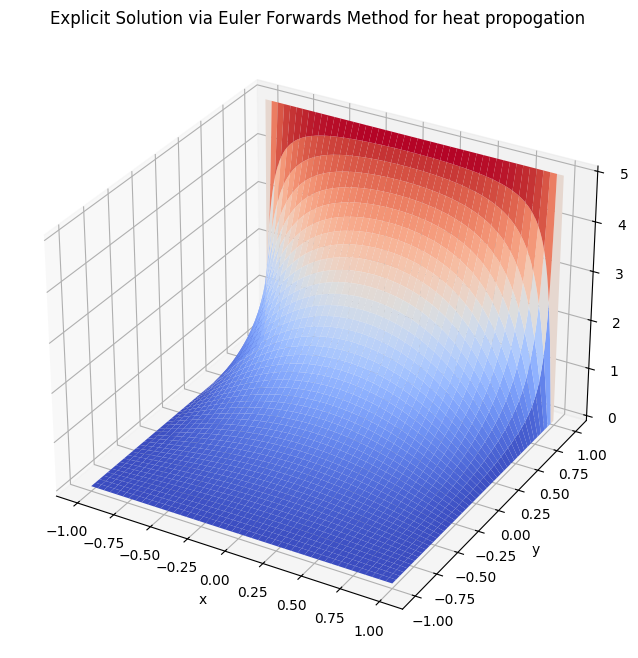

The time at which the central temperature reaches 1 in this implementation is: 0.42400756143682733


In [ ]:
#Create a new plot
length = len(U)
fig = plt.figure(figsize=(8, 8)) 
#Define the type of figure
ax = fig.add_subplot(projection='3d') 
#Create axes
ticks= np.linspace(-1, 1, U.shape[1]) 
X, Y = np.meshgrid(ticks, ticks) 
#Define surface
surf = ax.plot_surface(X, Y, U[length - 1], 
                       antialiased=True, cmap=cm.coolwarm) 
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y)')
ax.set_title('Explicit Solution via Euler Forwards Method for heat propogation')
plt.show()
print("The time at which the central temperature reaches 1 in this implementation is:",timer)

Above is a 3D plot with the x and y axis representing the dimensions of the plate in the final timestep and the z axis and the colours representing the heat at each point on the plate. I will use this format to represent all the timestepping techniques used.

In [110]:
times,central_temps = time_central_val(np.arange(21,101,10),max_time = 1)

100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


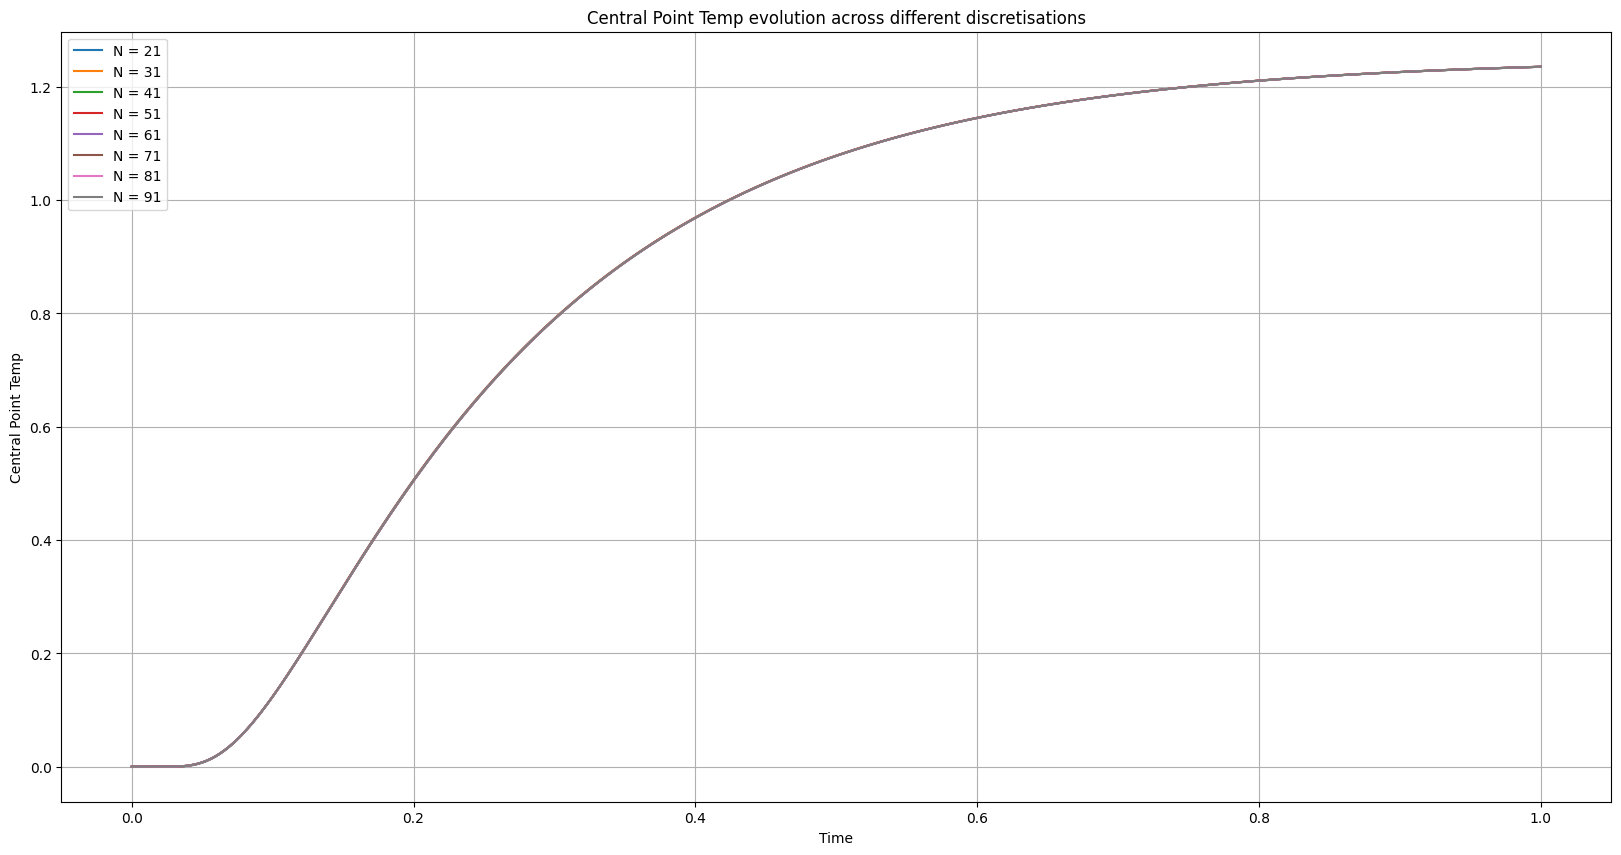

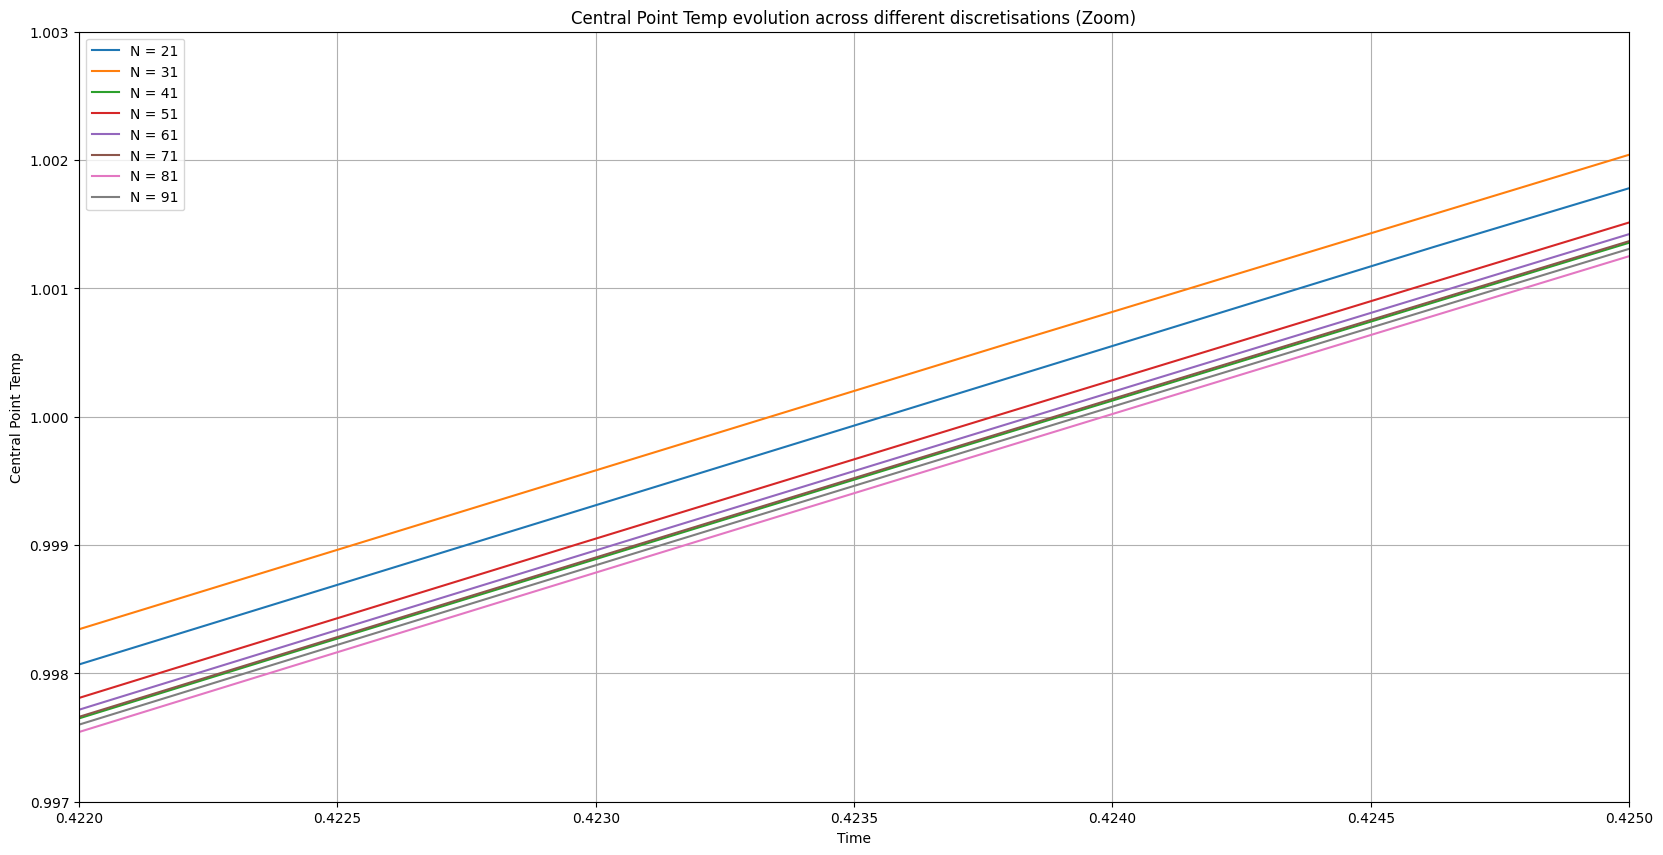

In [119]:
plt.figure(figsize=(20,10))
plt.title('Central Point Temp evolution across different discretisations')
plt.xlabel('Time')
plt.ylabel('Central Point Temp')
for i in range(len(central_temps)):
    plt.plot(np.linspace(0,1,len(central_temps[i])),central_temps[i],label=f'N = {np.arange(21,101,10)[i]}')
plt.legend(loc='best')
plt.grid()

plt.figure(figsize=(20,10))
plt.title('Central Point Temp evolution across different discretisations (Zoom)')
plt.xlabel('Time')
plt.ylabel('Central Point Temp')
plt.xlim(right = 0.425,left = 0.422)
plt.ylim(top = 1.003,bottom = 0.997)
for i in range(len(central_temps)):
    plt.plot(np.linspace(0,1,len(central_temps[i])),central_temps[i],label=f'N = {np.arange(21,101,10)[i]}')
plt.legend(loc='best')
plt.grid()

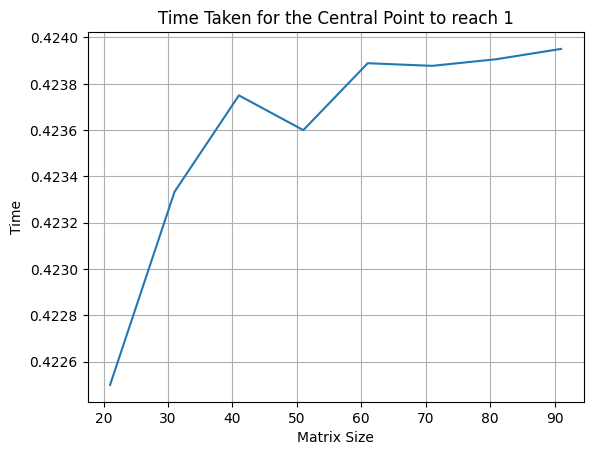

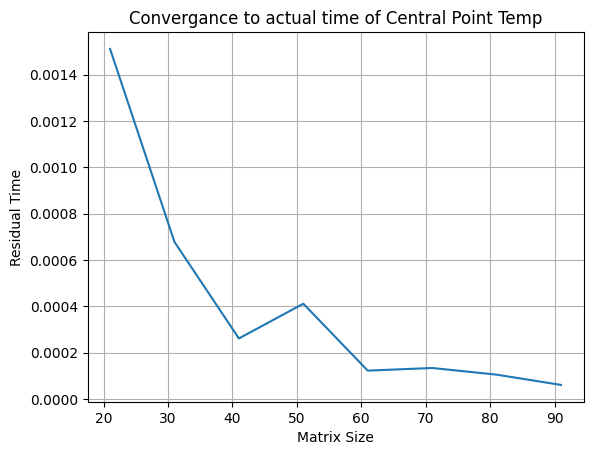

In [6]:
plt.figure()
plt.title('Time Taken for the Central Point to reach 1')
plt.plot(np.arange(21,101,10),times)
plt.xlabel('Matrix Size')
plt.ylabel('Time')
plt.grid(True)

plt.figure()
plt.title('Convergance to actual time of Central Point Temp')
plt.plot(np.arange(21,101,10),0.424011387033 - np.array(times))
plt.xlabel('Matrix Size')
plt.ylabel('Residual Time')
plt.grid(True)

In [7]:
times,central_temps = time_central_val(np.arange(21,271,50))

100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


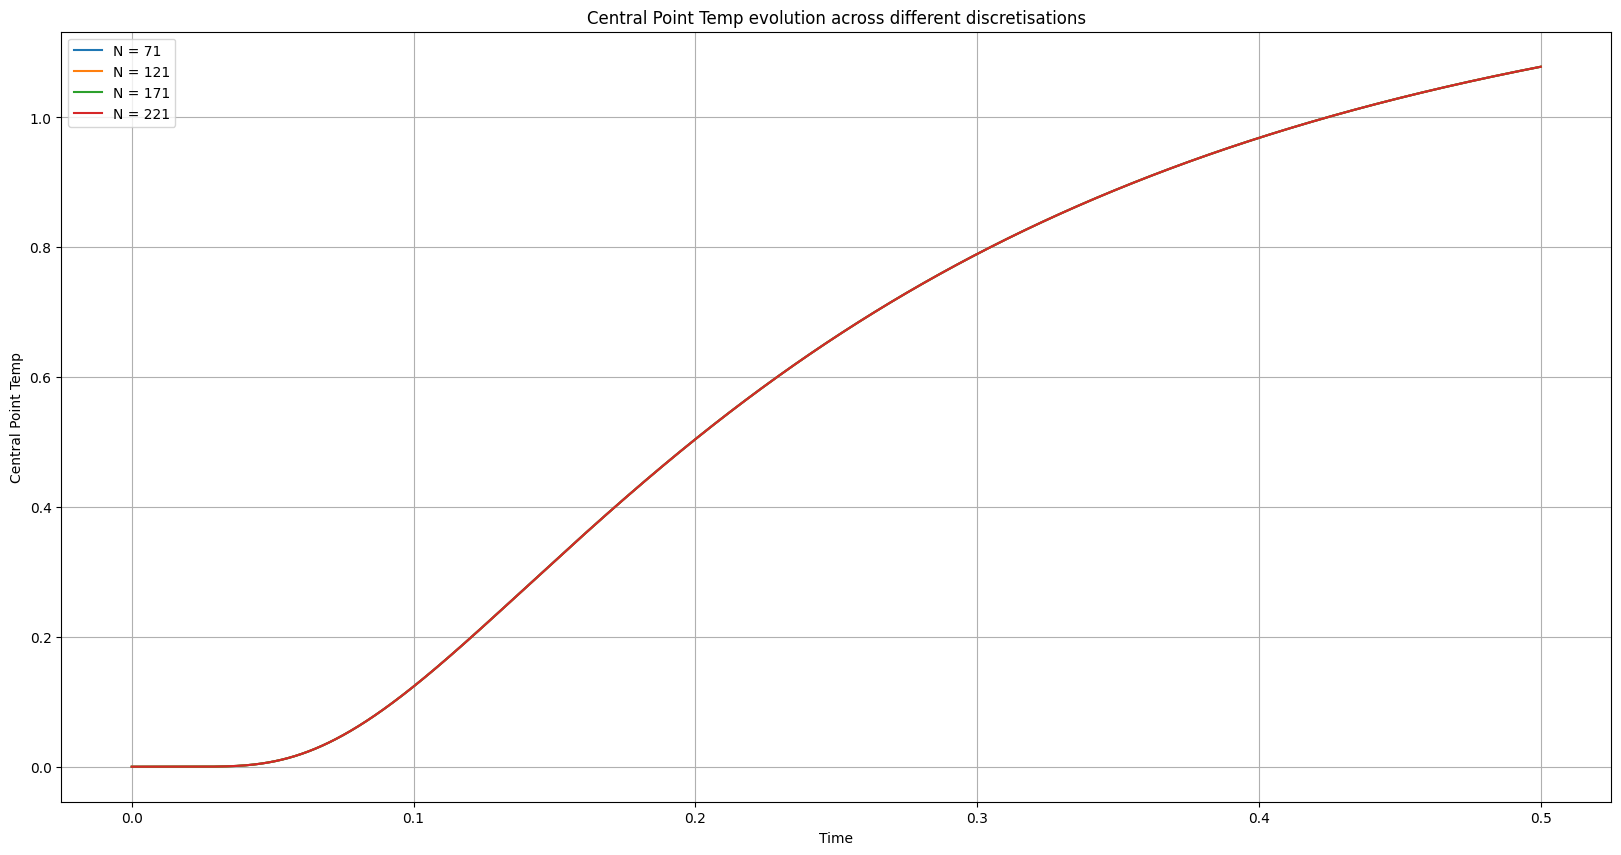

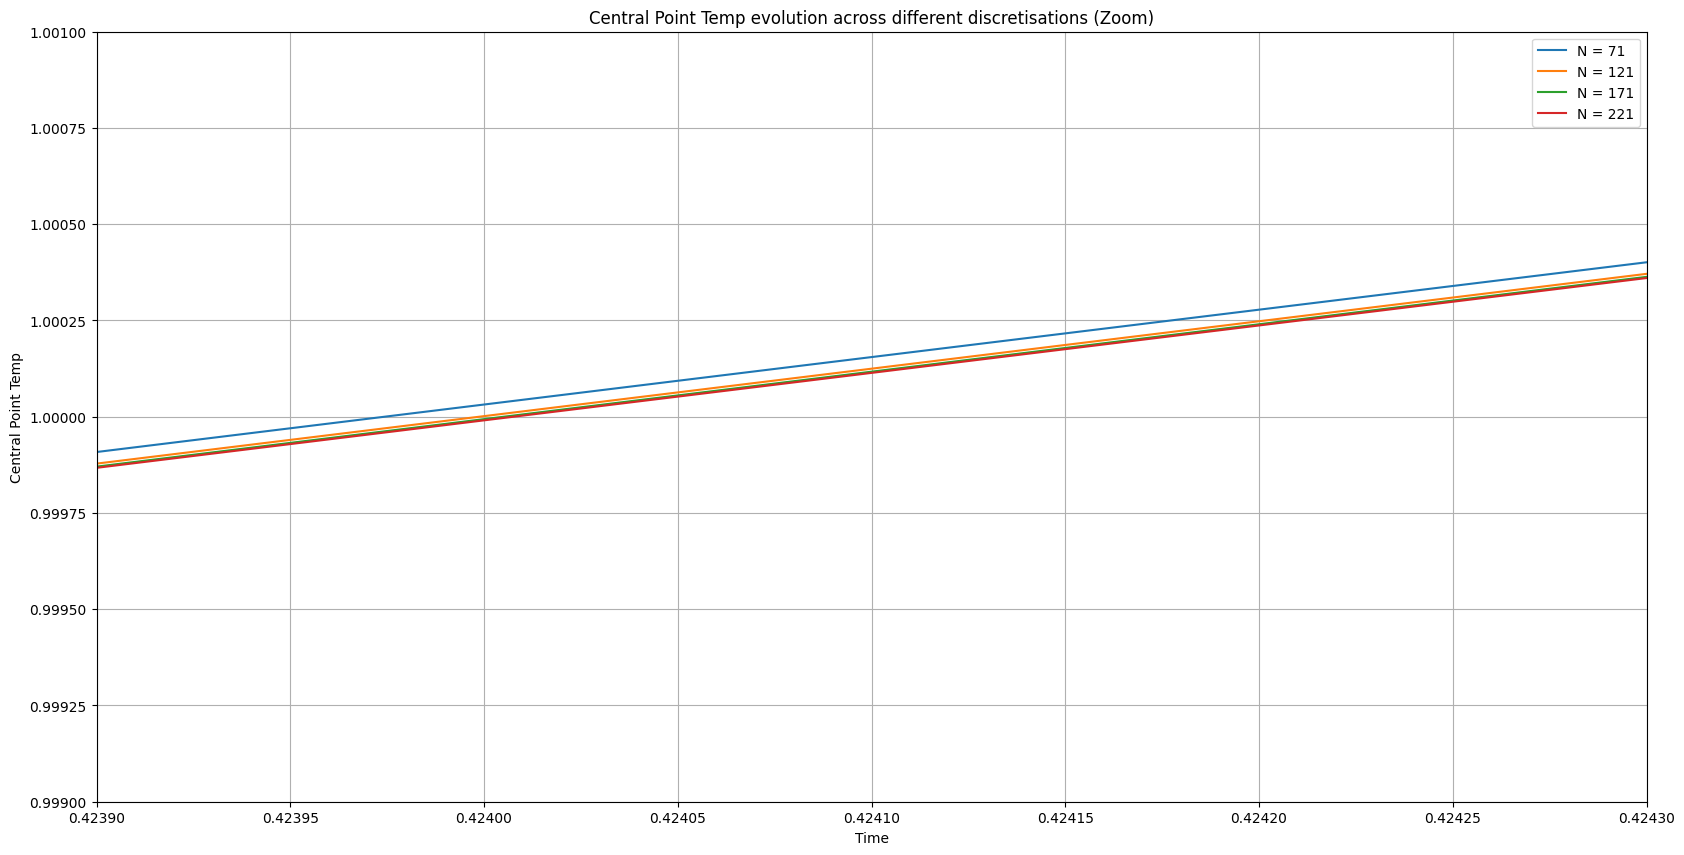

In [77]:
plt.figure(figsize=(20,10))
plt.title('Central Point Temp evolution across different discretisations')
plt.xlabel('Time')
plt.ylabel('Central Point Temp')
for i in range(1,len(central_temps)):
    plt.plot(np.linspace(0,0.5,len(central_temps[i])),central_temps[i],label=f'N = {np.arange(21,271,50)[i]}')
plt.legend(loc='best')
plt.grid()

plt.figure(figsize=(20,10))
plt.title('Central Point Temp evolution across different discretisations (Zoom)')
plt.xlabel('Time')
plt.ylabel('Central Point Temp')
for i in range(1,len(central_temps)):
    plt.plot(np.linspace(0,0.5,len(central_temps[i])),central_temps[i],label=f'N = {np.arange(21,271,50)[i]}')
plt.xlim(left = 0.4239,right = 0.4243)
plt.ylim(top = 1.001,bottom = 0.999)
plt.legend(loc='best')
plt.grid()

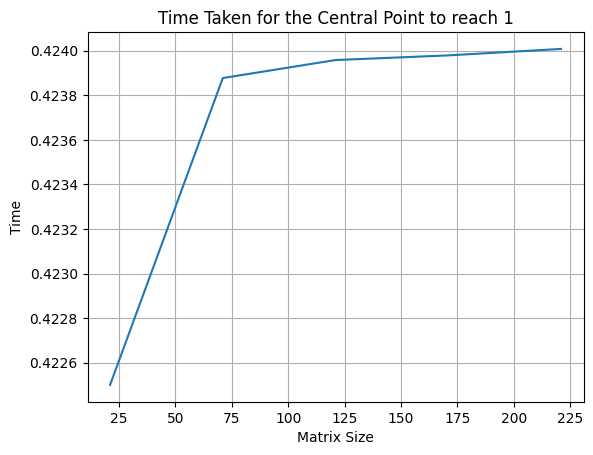

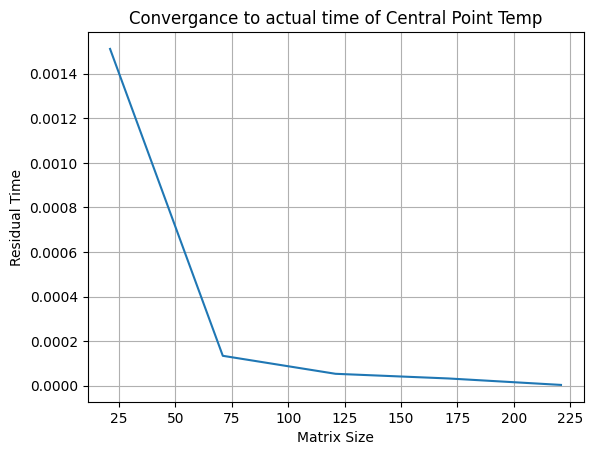

In [10]:
plt.figure()
plt.title('Time Taken for the Central Point to reach 1')
plt.plot(np.arange(21,271,50),times)
plt.xlabel('Matrix Size')
plt.ylabel('Time')
plt.grid(True)

plt.figure()
plt.title('Convergance to actual time of Central Point Temp')
plt.plot(np.arange(21,271,50),0.424011387033 - np.array(times))
plt.xlabel('Matrix Size')
plt.ylabel('Residual Time')
plt.grid(True)

Since the time stops being recorded when the heat of the plate stops being below 1, the estimated time remains below the actual time with the residual to the actual time being dependent on the timestep $\Delta t$. The timestep $\Delta t$ becomes exponentially smaller as the distance interval $\Delta x$ decreases. This explains the residual of time's exponential decay as matrix size increases. The reason why the time is underestimated at smaller discretisation numbers is because in the explicit time stepping scheme at lower N values teh heat propogation is overpropagated. This can be seen in the plots above. This is because of the reliance on local, current information leading to exaggerated timesteps when granularity is low.

### Improved CPU implementation

Previously the entire matrix containing the temperatures of the plate at all points in time was stored. I will now amend the euler forwards method so that it only stores the relevant two timesteps at a time. This should massively conserve RAM making the upper limit on the size of N that can be used the time it takes to run instead of the amount of RAM. The drawback of this method is that to achieve higher precision a large number of timesteps are needed which increases the computational time to hours. Copying the heat of the plate in the 1 index to the 0 index also increases the computational time.

In [11]:
@njit(parallel=True)
def iterate_dt_efficient(u,N,C):
    for i in prange(1,N-1):
        for j in range(1,N-1):
            u[1,i,j] = C * (u[0,i+1,j] + u[0,i - 1,j] + u[0,i,j+1] +
                                        u[0,i,j-1] - 4 * u[0,i,j]) + u[0,i,j]
    return u
def forward_euler_cpu_efficient(N, max_time = 0.45,C = 0.25,timesteps = None):
    assert N%2 != 0,"For there to be a central discretisation point the number of points N must be odd. Please input an odd number." 
    #check if number is odd or even
    dx = 2/(N-1)
    dt = C * dx**2
    if timesteps == None:
        timesteps = int(max_time/dt)
    u = np.zeros((2,N,N))
    u[:,(N-1),:] = 5
    counter = 0
    central_temps = np.empty(timesteps)
    for i in range(timesteps-1):
        u[0,:,:] = u[1,:,:]
        u = iterate_dt_efficient(u,N,C)
        central_temp = u[0,N//2,N//2]
        central_temps[i] = central_temp
        if central_temp < 1:
            counter += dt
    central_temps[-1] = u[-1,N//2,N//2]
    return u, central_temps,counter

In [12]:
times_efficient,central_temps_efficient = time_central_val(np.arange(21,1001,10),func = forward_euler_cpu_efficient)

100%|██████████| 98/98 [2:10:59<00:00, 80.20s/it]   


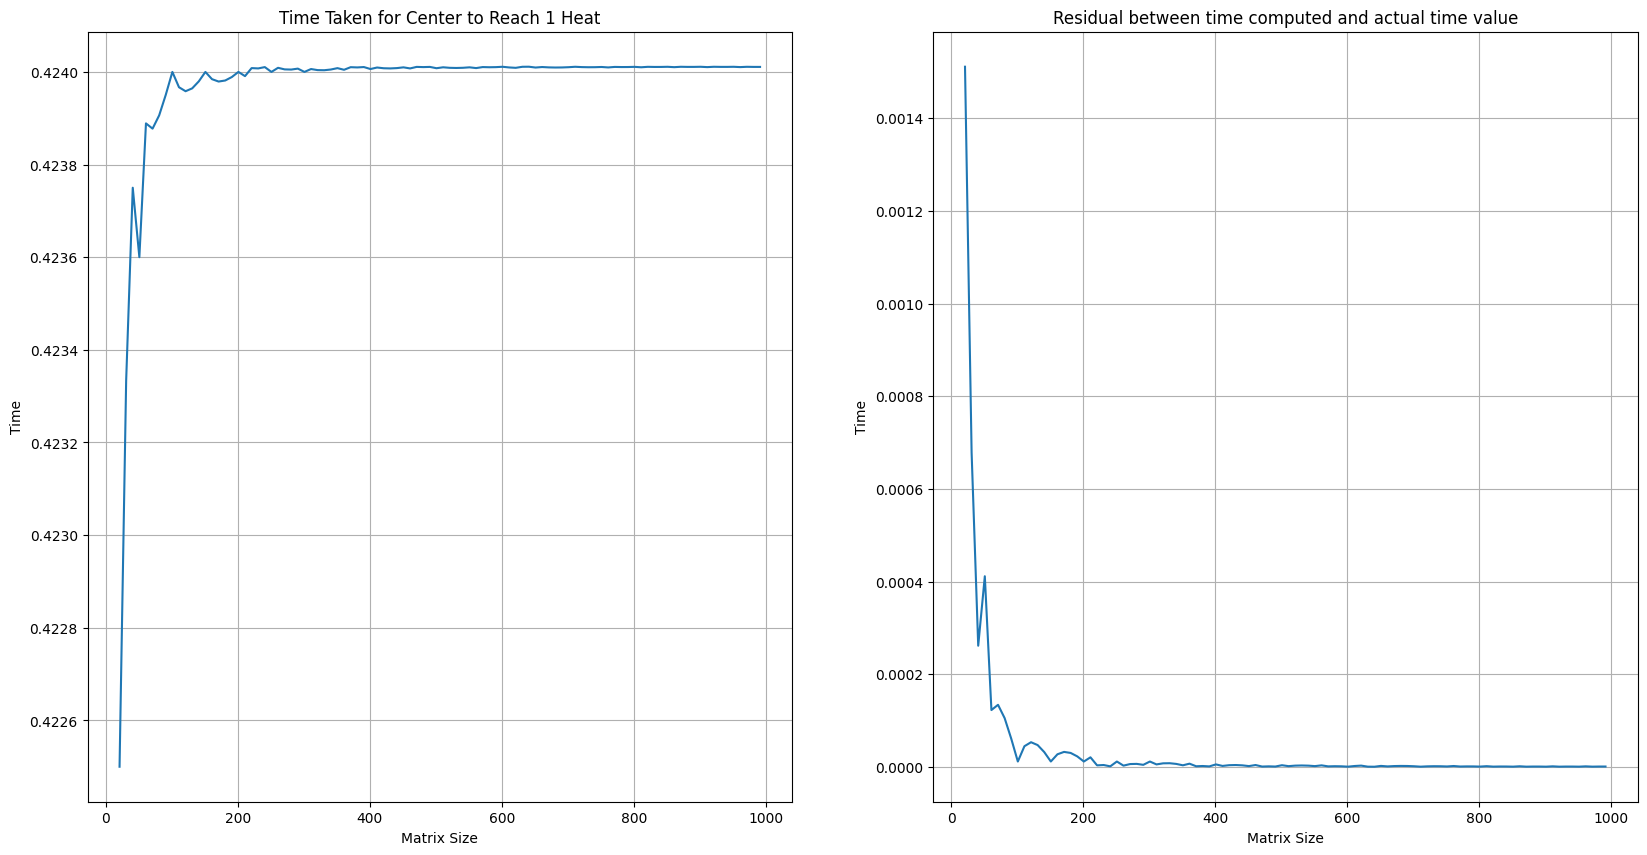

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
ax1.plot(np.arange(21,1001,10),times_efficient)
ax1.set_title('Time Taken for Center to Reach 1 Heat')
ax1.set_xlabel('Matrix Size')
ax1.set_ylabel('Time')
ax2.set_ylabel('Time')
ax2.set_xlabel('Matrix Size')
ax2.plot(np.arange(21,1001,10),0.424011387033-np.array(times_efficient))
ax2.set_title('Residual between time computed and actual time value')
ax1.grid(True)
ax2.grid(True)

In [68]:
times_efficient[-1]

0.42401081521876305

It can be seen above that the numba JIT CPU implementation which returns a convergance time of 0.4240108 achieves up to 5 decimal places of precision when 1000 discretisation points are used. When rounded to 6 decimal places it can be said to be to 6 digits of precision to the real answer of $t^* = 0.424011387033$. 

### CUDA GPU implemenation

Now that I have used numba CPU JIT compilation to implement an explicit forwards euler scheme to find the time at which the center temperature reaches 1 I will use a CUDA GPU implementation. This approach also avoids storing the whole three dimensional matrix of the plate discretisation points heat level at each timestep.

In [1]:
from numba import cuda
###### First I will test that my CUDA is able to access my laptop's GPU
@cuda.jit
def dummy_kernel(x):
    pass  # Does nothing, just a placeholder

def main():
    # Allocate a small amount of memory
    x_device = cuda.device_array(10)
    dummy_kernel[1, 1](x_device)

    print("CUDA test completed successfully.")

if __name__ == '__main__':
    main()


CUDA test completed successfully.


/home/gsaba/.local/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [14]:
import numpy as np
from numba import cuda, float32

@cuda.jit
def gpu_euler_kernel(u, U, C, N):
    tx = cuda.threadIdx.x
    bx = cuda.blockIdx.x
    bw = cuda.blockDim.x

    j = tx + bx * bw

    if 0 < j < N - 1:
        for i in range(1, N - 1):
            idx = j * N + i
            U[idx] = C * (u[idx - N] + u[idx + N] + u[idx - 1] + u[idx + 1] - 4 * u[idx]) + u[idx]

def gpu_euler(N, max_time=0.45, C=0.25, timesteps=None,threads_per_block = 32):
    dx = 2 / (N - 1)
    dt = C *dx ** 2
    timesteps = int(max_time / dt) if timesteps is None else timesteps

    u = np.zeros((N, N), dtype=np.float32)
    u[-1, :] = 5  # Boundary condition
    u = u.reshape(N ** 2)
    U = u.copy()

    u_gpu = cuda.to_device(u)
    U_gpu = cuda.to_device(U)

    blocks_per_grid = (u.size + threads_per_block - 1) // threads_per_block

    midpoints = []
    counter = 0

    for k in range(timesteps):
        gpu_euler_kernel[blocks_per_grid, threads_per_block](u_gpu, U_gpu, C, N)
        u_gpu, U_gpu = U_gpu, u_gpu  # Swap references
        mid_temp = U_gpu[N//2 * N + N//2]
        #U_gpu.copy_to_host(u)
        #mid_temp = u.reshape(N, N)[N // 2, N // 2]
        if mid_temp < 1:
            counter += dt
        midpoints.append(mid_temp)

    # Final copy to get the last state
    U_gpu.copy_to_host(u)
    u = u.reshape(N, N)
    return u,midpoints, counter

In [26]:
%%time
forward_euler_cpu_efficient(421) #### compare cpu run time to gpu run time.

CPU times: user 4min 29s, sys: 250 ms, total: 4min 29s
Wall time: 16.9 s


(array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.94099547e-05, 3.88187456e-05, ...,
          3.88187456e-05, 1.94099547e-05, 0.00000000e+00],
         [0.00000000e+00, 3.88222552e-05, 7.76421826e-05, ...,
          7.76421826e-05, 3.88222552e-05, 0.00000000e+00],
         ...,
         [0.00000000e+00, 1.51164831e+00, 2.49982389e+00, ...,
          2.49982389e+00, 1.51164831e+00, 0.00000000e+00],
         [0.00000000e+00, 2.49995597e+00, 3.48817557e+00, ...,
          3.48817557e+00, 2.49995597e+00, 0.00000000e+00],
         [5.00000000e+00, 5.00000000e+00, 5.00000000e+00, ...,
          5.00000000e+00, 5.00000000e+00, 5.00000000e+00]],
 
        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.94102502e-05, 3.88193366e-05, ...,
          3.88193366e-05, 1.94102502e-05, 0.00000000e+00],
       

In [72]:
%%time
##### To directly compare the GPU implementation to the CPU implementation I will again use N = 421 discretisation points
u,midpoints, counter = gpu_euler(421)
print("The time taken for the temperature of the central point to reach 1 is ",counter)

The time taken for the temperature of the central point to reach 1 is  0.4240136054423937
CPU times: user 19.1 s, sys: 681 ms, total: 19.7 s
Wall time: 19.7 s


In [16]:
%%time
##### To directly compare the GPU implementation to the CPU implementation I will again use N = 231 discretisation points
u,midpoints, counter = gpu_euler(231)
print("The time taken for the temperature of the central point to reach 1 is ",counter)

The time taken for the temperature of the central point to reach 1 is  0.42400756143682733
CPU times: user 4.19 s, sys: 200 ms, total: 4.39 s
Wall time: 4.39 s


Here the GPU implementation is accurate to 4 decimal places past with grid sizes past 200 and at 421 grid size an accuracy of up to 5 decimal places is even used. The time taken for the central point to reach 1 heat appears to be the same in the CPU JIT approach and the GPU cuda approach as teh calculations being carried out are the same with the gpu implementation only being more efficient. It should be noted that the GPU's overestimation tendencies can be seen here.

In [54]:
%%time
u, midpoints, counter = gpu_euler(501)
print("The time taken for the temperature of the central point to reach 1 is ",counter)

The time taken for the temperature of the central point to reach 1 is  0.4240240000003414
CPU times: user 28.4 s, sys: 860 ms, total: 29.3 s
Wall time: 29.3 s


When 501 discretisation points are used the time recorded for the temperature of the central point to reach 1 is 0.424024 which is correct to 4 decimal places. This can be compared to the CPU version where even when it was ran for 1000 discretisation points only an accuracy of two decimal places to the real solution was used. Below I will plot a heatmap of the final heat of the plate.

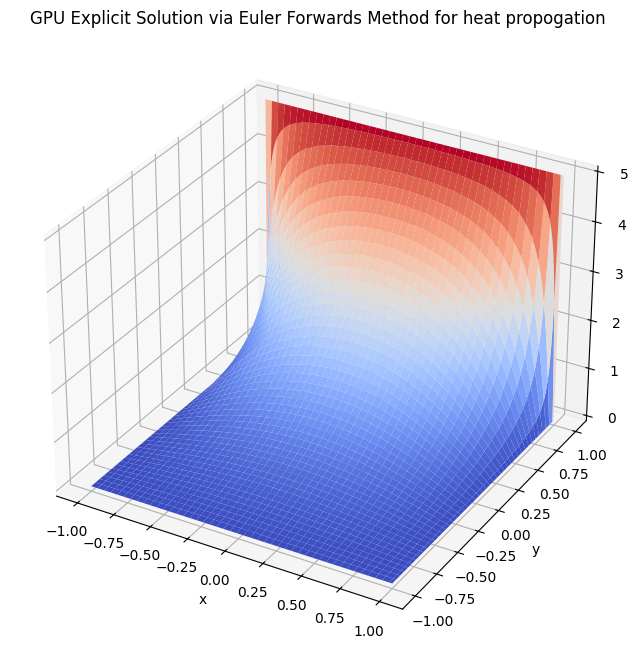

The time at which the central temperature reaches 1 in this implementation is: 0.42401249999984547


In [20]:
#Create a new plot
fig = plt.figure(figsize=(8, 8)) 
#Define the type of figure
ax = fig.add_subplot(projection='3d') 
#Create axes
ticks= np.linspace(-1, 1, u.shape[1]) 
X, Y = np.meshgrid(ticks, ticks) 
#Define surface
surf = ax.plot_surface(X, Y, u, 
                       antialiased=True, cmap=cm.coolwarm) 
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y)')
ax.set_title('GPU Explicit Solution via Euler Forwards Method for heat propogation')
plt.show()
print("The time at which the central temperature reaches 1 in this implementation is:",counter)

#### GPU Implementation Plots of Central Point Heat Time Evolution

In [70]:
times_GPU_270,central_temps_GPU_270 = time_central_val(np.arange(21,271,50),func = gpu_euler)

100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


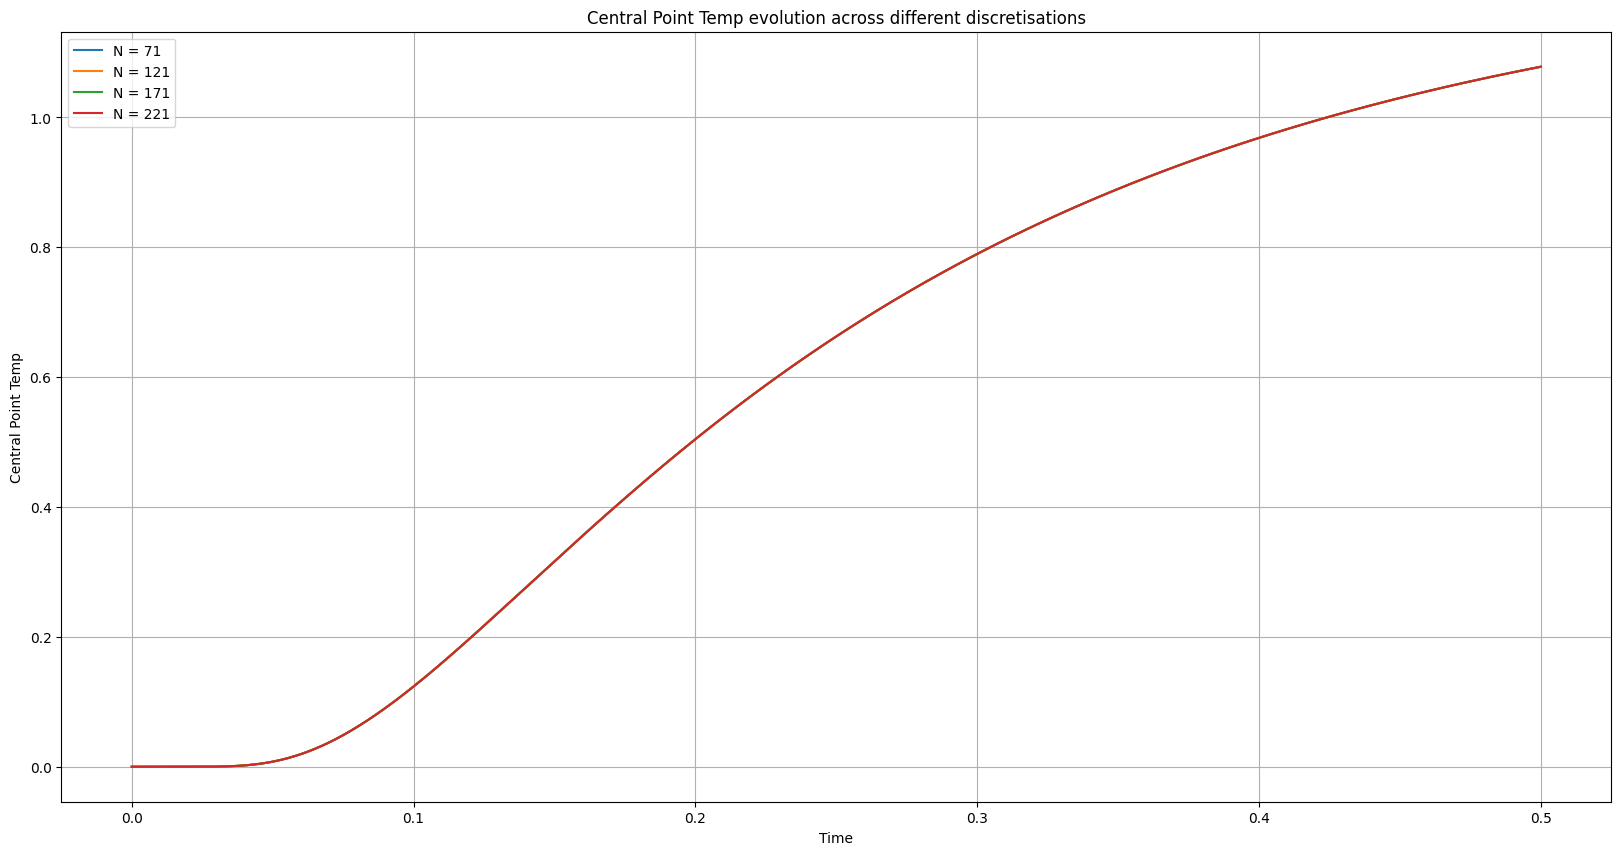

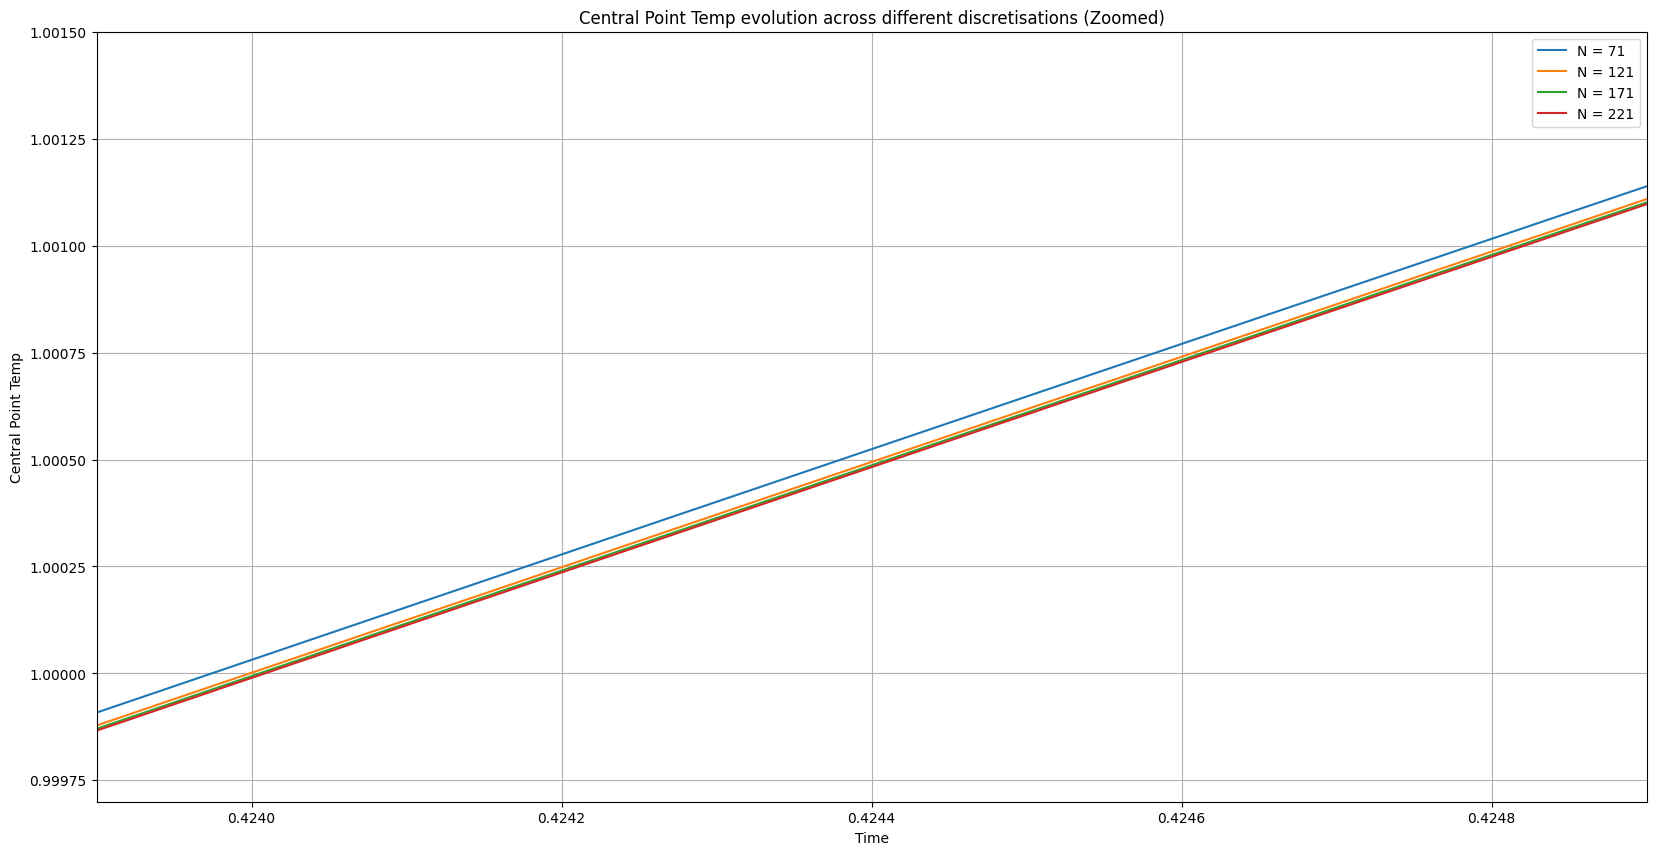

In [82]:
plt.figure(figsize=(20,10))
plt.title('Central Point Temp evolution across different discretisations')
plt.xlabel('Time')
plt.ylabel('Central Point Temp')
for i in range(1,len(central_temps_GPU_270)):
    plt.plot(np.linspace(0,0.5,len(central_temps_GPU_270[i])),central_temps_GPU_270[i],label=f'N = {np.arange(21,271,50)[i]}')
plt.legend(loc='best')
plt.grid()

plt.figure(figsize=(20,10))
plt.title('Central Point Temp evolution across different discretisations (Zoomed)')
plt.xlabel('Time')
plt.ylabel('Central Point Temp')
for i in range(1,len(central_temps_GPU_270)):
    plt.plot(np.linspace(0,0.5,len(central_temps_GPU_270[i])),central_temps_GPU_270[i],label=f'N = {np.arange(21,271,50)[i]}')
plt.xlim(left = 0.4239,right = 0.4249)
plt.ylim(top = 1.0015,bottom = 0.9997)
plt.legend(loc='best')
plt.grid()

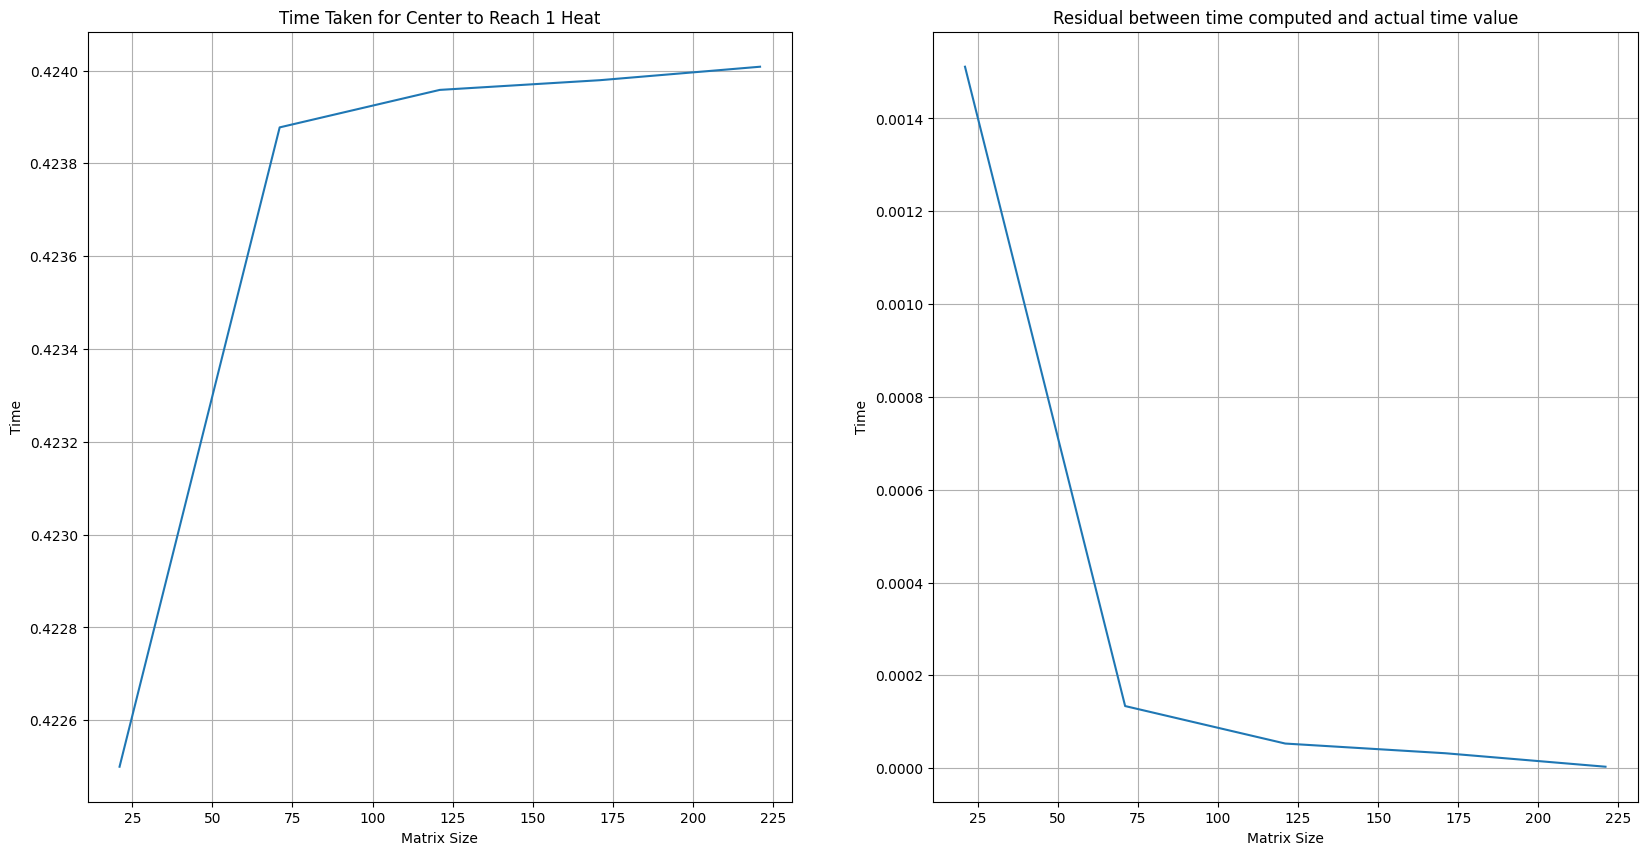

In [26]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
ax1.plot(np.arange(21,271,50),times_GPU_270)
ax1.set_title('Time Taken for Center to Reach 1 Heat')
ax1.set_xlabel('Matrix Size')
ax1.set_ylabel('Time')
ax2.set_ylabel('Time')
ax2.set_xlabel('Matrix Size')
ax2.plot(np.arange(21,271,50),0.424011387033-np.array(times_GPU_270))
ax2.set_title('Residual between time computed and actual time value')
ax1.grid(True)
ax2.grid(True)

In [24]:
times_GPU_1000,central_temps_GPU_1000 = time_central_val(np.arange(21,1001,100),func = gpu_euler)

100%|██████████| 10/10 [08:13<00:00, 49.38s/it]


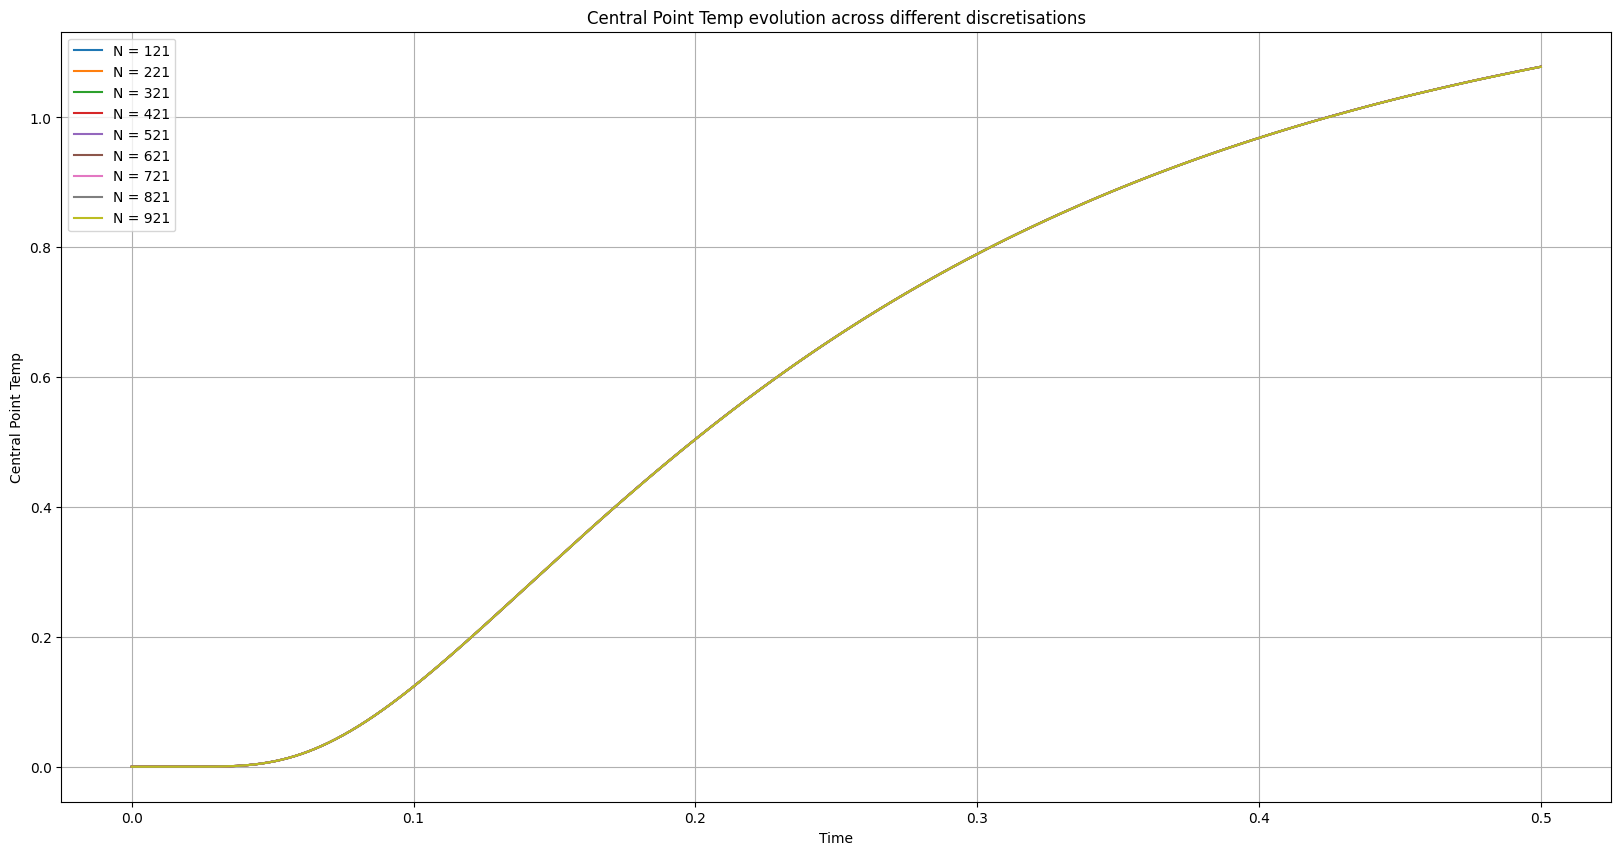

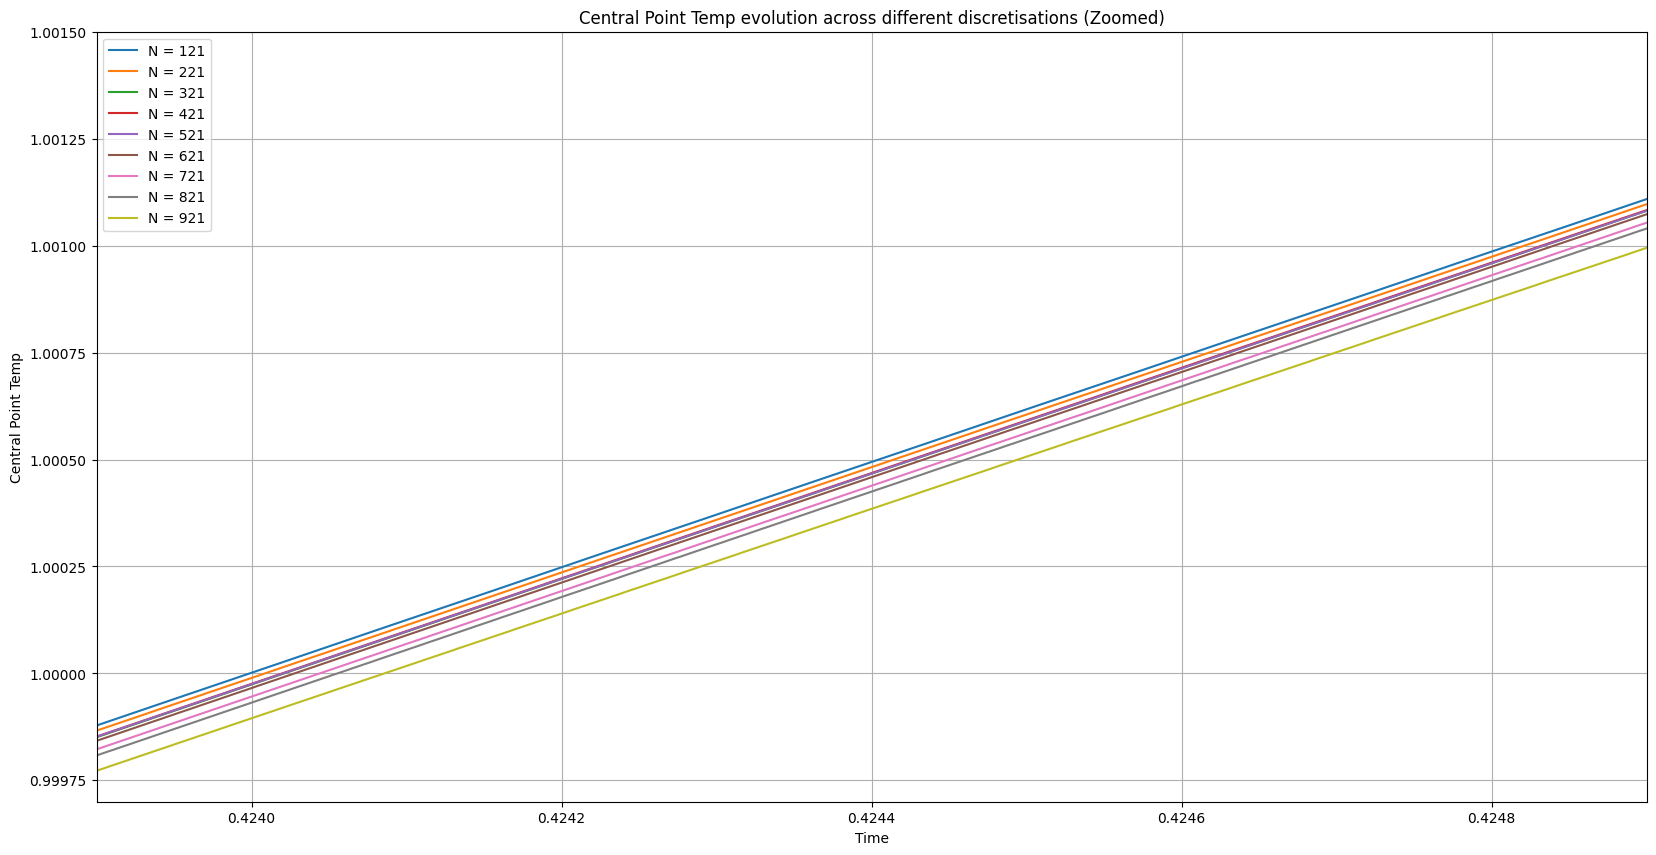

In [83]:
plt.figure(figsize=(20,10))
plt.title('Central Point Temp evolution across different discretisations')
plt.xlabel('Time')
plt.ylabel('Central Point Temp')
for i in range(1,len(central_temps_GPU_1000)):
    plt.plot(np.linspace(0,0.5,len(central_temps_GPU_1000[i])),central_temps_GPU_1000[i],label=f'N = {np.arange(21,1001,100)[i]}')
plt.legend(loc='best')
plt.grid()

plt.figure(figsize=(20,10))
plt.title('Central Point Temp evolution across different discretisations (Zoomed)')
plt.xlabel('Time')
plt.ylabel('Central Point Temp')
for i in range(1,len(central_temps_GPU_1000)): # excluding 21 because too low
    plt.plot(np.linspace(0,0.5,len(central_temps_GPU_1000[i])),central_temps_GPU_1000[i],label=f'N = {np.arange(21,1001,100)[i]}')
plt.xlim(left = 0.4239,right = 0.4249)
plt.ylim(top = 1.0015,bottom = 0.9997)
plt.legend(loc='best')
plt.grid()

When 1001 discretisation points are used with the GPU implementation the time taken for the central point to reach a heat of 1 is 0.4240843572748035 .


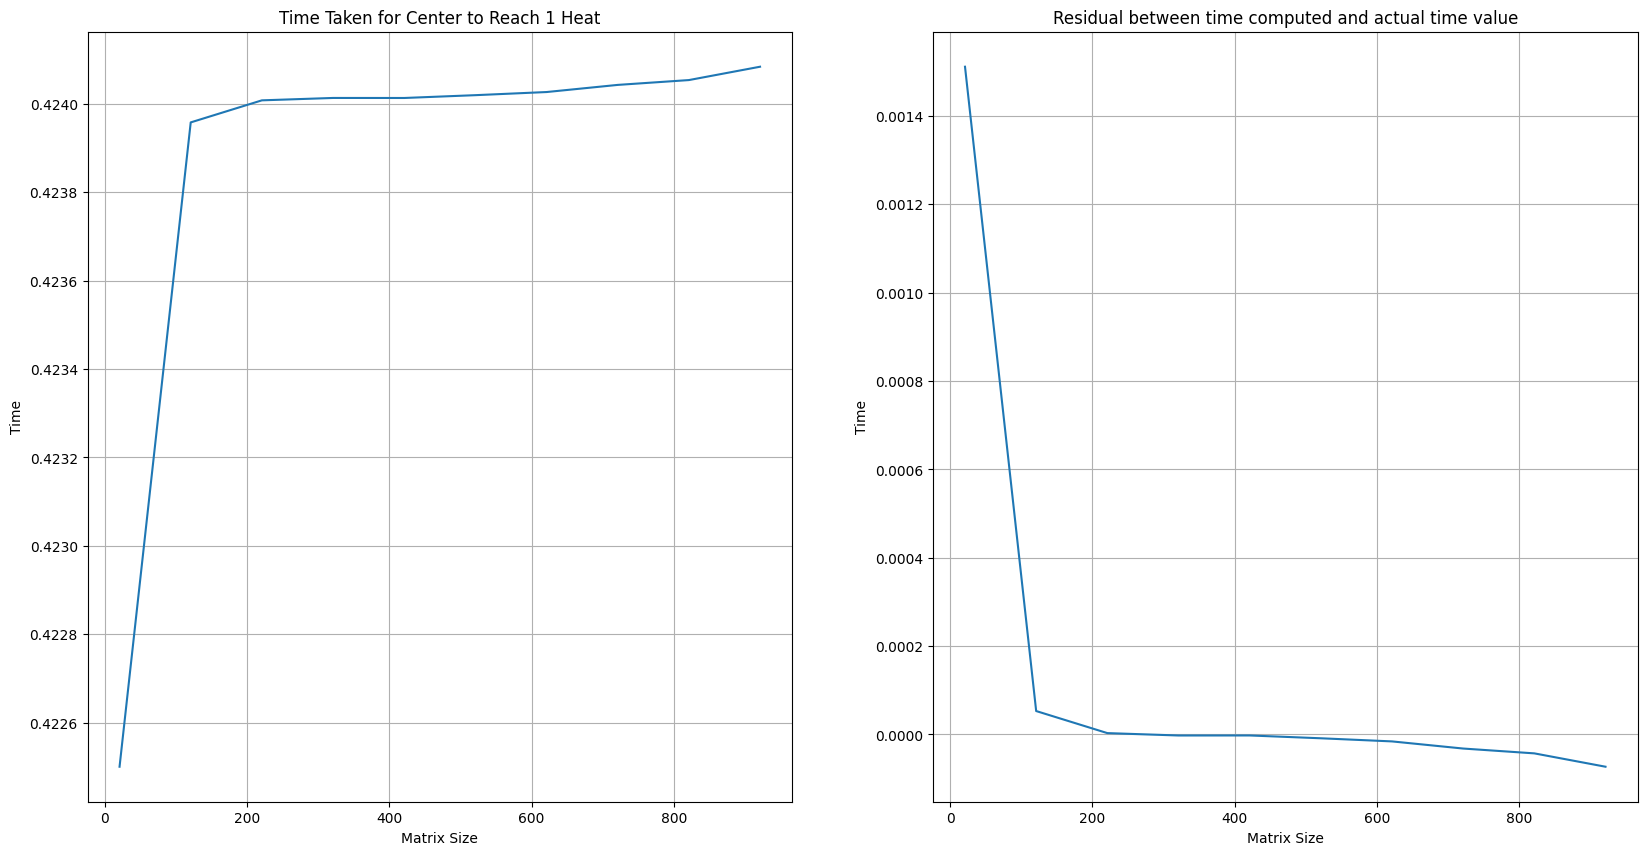

In [67]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
ax1.plot(np.arange(21,1001,100),times_GPU_1000)
ax1.set_title('Time Taken for Center to Reach 1 Heat')
ax1.set_xlabel('Matrix Size')
ax1.set_ylabel('Time')
ax2.set_ylabel('Time')
ax2.set_xlabel('Matrix Size')
ax2.plot(np.arange(21,1001,100),0.424011387033-np.array(times_GPU_1000))
ax2.set_title('Residual between time computed and actual time value')
ax1.grid(True)
ax2.grid(True)

print("When 1001 discretisation points are used with the GPU implementation the time taken for the central point to reach a heat of 1 is",
      times_GPU_1000[-1],".")

In [100]:
%%time
a,b,c = gpu_euler(501,threads_per_block=1024)

CPU times: user 55.7 s, sys: 1.09 s, total: 56.8 s
Wall time: 56.8 s


In [101]:
%%time
d,e,f = gpu_euler(501,threads_per_block = 512)

CPU times: user 54.9 s, sys: 1.2 s, total: 56.1 s
Wall time: 56.1 s


In [83]:
%%time
d,e,f = gpu_euler(501)

CPU times: user 28.4 s, sys: 950 ms, total: 29.4 s
Wall time: 29.4 s


In [84]:
%%time
d,e,f = gpu_euler(501,threads_per_block=16)

CPU times: user 27.8 s, sys: 970 ms, total: 28.8 s
Wall time: 28.7 s


In [92]:
%%time
d,e,f = gpu_euler(501,threads_per_block=4)

CPU times: user 24.9 s, sys: 710 ms, total: 25.6 s
Wall time: 25.6 s


It can be seen in the explicit implementation that the scheme in general overestimates the heat at the central point at lower discretisations. This explains why the convergence time is underestimated in this implementation at lower N discretisation points. One thing that is interesting about the GPU scheme is that it is faster the less threads_per_block there are. This can be explained by the fact that if there are less threads per block there are more blocks per grid increasing the capacity for parallelisation. The gpu implementation overall appears to be faster than the CPU implementation demonstrated when their speed where compared for N = 421 due to the capacity for parallelisation that GPUs possess however the CPU approach seems to be more stable at higher discretisation points. When the GPU explicit approach reaches 1000 points it begins to overestimate the the time taken for convergance however it remains extremely accurate at a grid size of 501. This disrepancy could be due to the way the gpu handles chunks of data at small intervals introducing an element of error meaning that for the highest level of accuracy a CPU approach is better but if a decent level of accuracy is desired but computed in less time the GPU approach is more optimal.

#### Implicit Time Stepping

Here the euler backwards implicit time stepping method will be covered. The implicitness comes from the fact that it is impossible to explicitly state relationship between $u_{t+1}$ and $u_t$. At every timestep the linear equation $u_t = (I - \Delta t \alpha)u_{t+1}$ can be solved using a sparse matrix solver by rewriting as $(I - \Delta t \alpha)^{-1} u_t= u_{t+1}$ which fits the form $x = A^{-1}b$ where the sparse solver solves for $x$.

In [56]:
def discretise_poisson(N,C,alpha):
    """
    Generate the matrix and rhs associated with the discrete Poisson operator. 
    This code is adapted from the lecture notes of PHAS0102 which can be found at https://tbetcke.github.io/hpc_lecture_notes/sparse_direct_solvers.html .
    """
    
    nelements = 5 * N**2 - 16 * N + 16  ### quantity of non zero elements
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                count += 1
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                data[count] = alpha
                data[count + 1 : count + 5] = - C
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr()

def backwards_euler(N,C = 0.25,max_time = 0.5):
    assert N%2 != 0, "Please input an odd grid size."
    counter = 0
    dx = 2/(N-1)
    dt = C * dx**2
    iterations = int(max_time//dt)
    alpha = 1 + 4*C
    u = np.zeros((N, N), dtype=np.float32)
    u[-1, :] = 5  # Boundary condition
    A = discretise_poisson(N,C,alpha)
    u = u.reshape(N**2)
    mid_temps = []
    for i in range(iterations):
        mid_temp = u[N//2 * N + N//2]
        u = spsolve(A,u)
        if mid_temp < 1:
            counter += dt
        mid_temps.append(mid_temp)
    return u, mid_temps, counter

This implicit method will use a sparse solver to repeatedly solve the equation $Ax = b$ repeatedly across many different iterations. Here A will represent $(I - \Delta t \alpha)$ which can also be expressed as $(1 + 4\frac{\Delta t}{(\Delta x)^2} - \frac{\Delta t}{(\Delta x)^2}\Delta).$ The trade off for the increased stability using this method is the extra overhead and computational time resulting from using a sparse matrix vector problem solver repeatedly making it massively more inefficient than the explicit euler method. As a result I will only make plots for up to N discretisation points of 100. It can be seen that for 51 discretisation points the backwards euler method reaches a convergence time of 0.4248000 which is accurate to 3 decimal places. This can be compared with the explicit method which is only accurate to 2 decimal places at the same number of discretisation points.This extra stability that the implicit solution offers gives a wide range of choice in the selection of parameters giving the numerical solution more description range. However the GPU is limited in the improvements it can give for a vast number of timesteps as its key strength is parallelisation and in timestepping each iteration is dependent on the previous one meaning there is a limit to the benefits it can offer.

In [60]:
print("When 51 discretisation points are used the calculated time is ",backwards_euler(51)[2])

When 51 discretisation points are used the calculated time is  0.42480000000000806


In [61]:
back_u, back_temp, back_counter = backwards_euler(101)

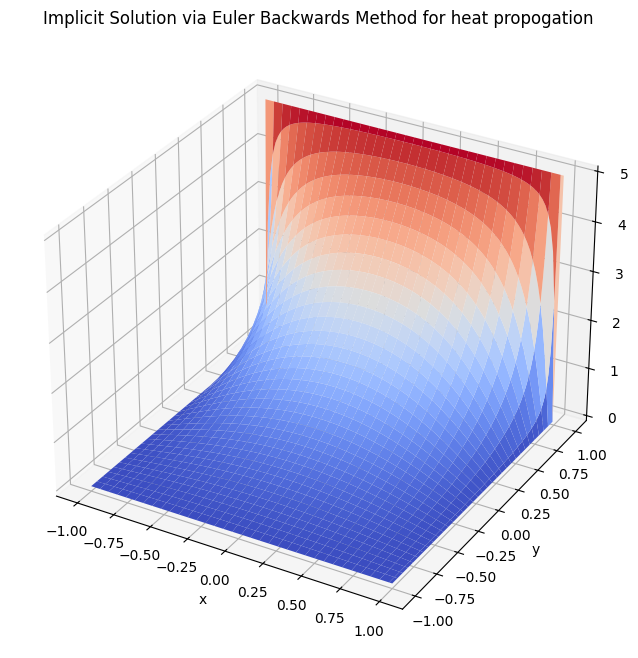

The time at which the central temperature reaches 1 in this implementation is: 0.4241999999999696


In [62]:
back_u = back_u.reshape(101,101)
#Create a new plot
fig = plt.figure(figsize=(8, 8)) 
#Define the type of figure
ax = fig.add_subplot(projection='3d') 
#Create axes
ticks= np.linspace(-1, 1, back_u.shape[0]) 
X, Y = np.meshgrid(ticks, ticks) 
#Define surface
surf = ax.plot_surface(X, Y, back_u, 
                       antialiased=True, cmap=cm.coolwarm) 
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y)')
ax.set_title('Implicit Solution via Euler Backwards Method for heat propogation')
plt.show()
print("The time at which the central temperature reaches 1 in this implementation is:",back_counter)

In [64]:
times_back_, central_temps_back = time_central_val(np.arange(21,101,10),func = backwards_euler)

100%|██████████| 8/8 [02:00<00:00, 15.10s/it]


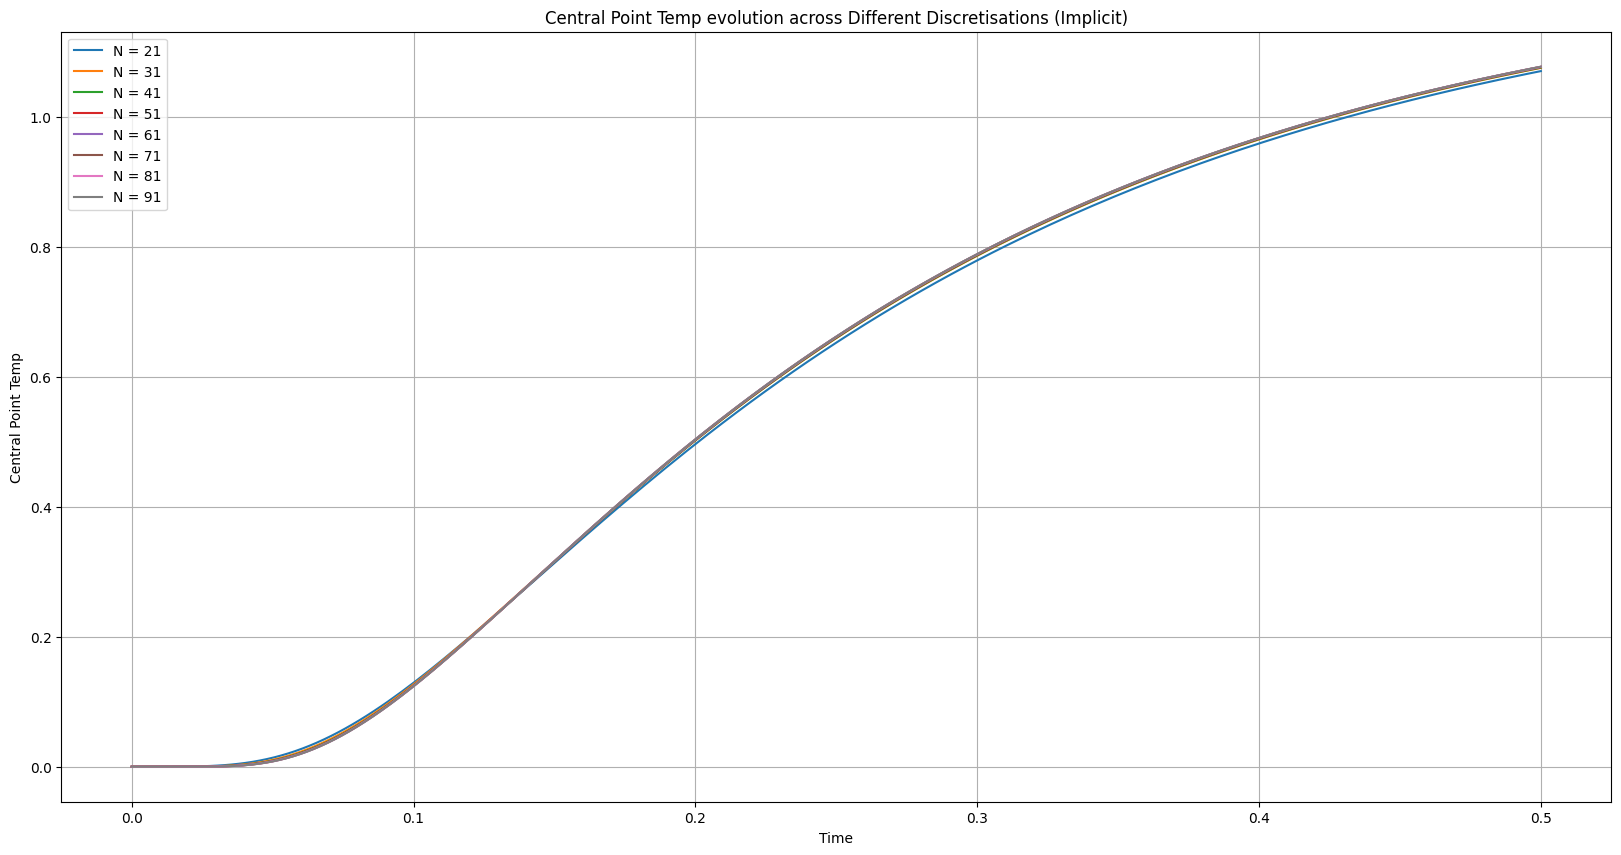

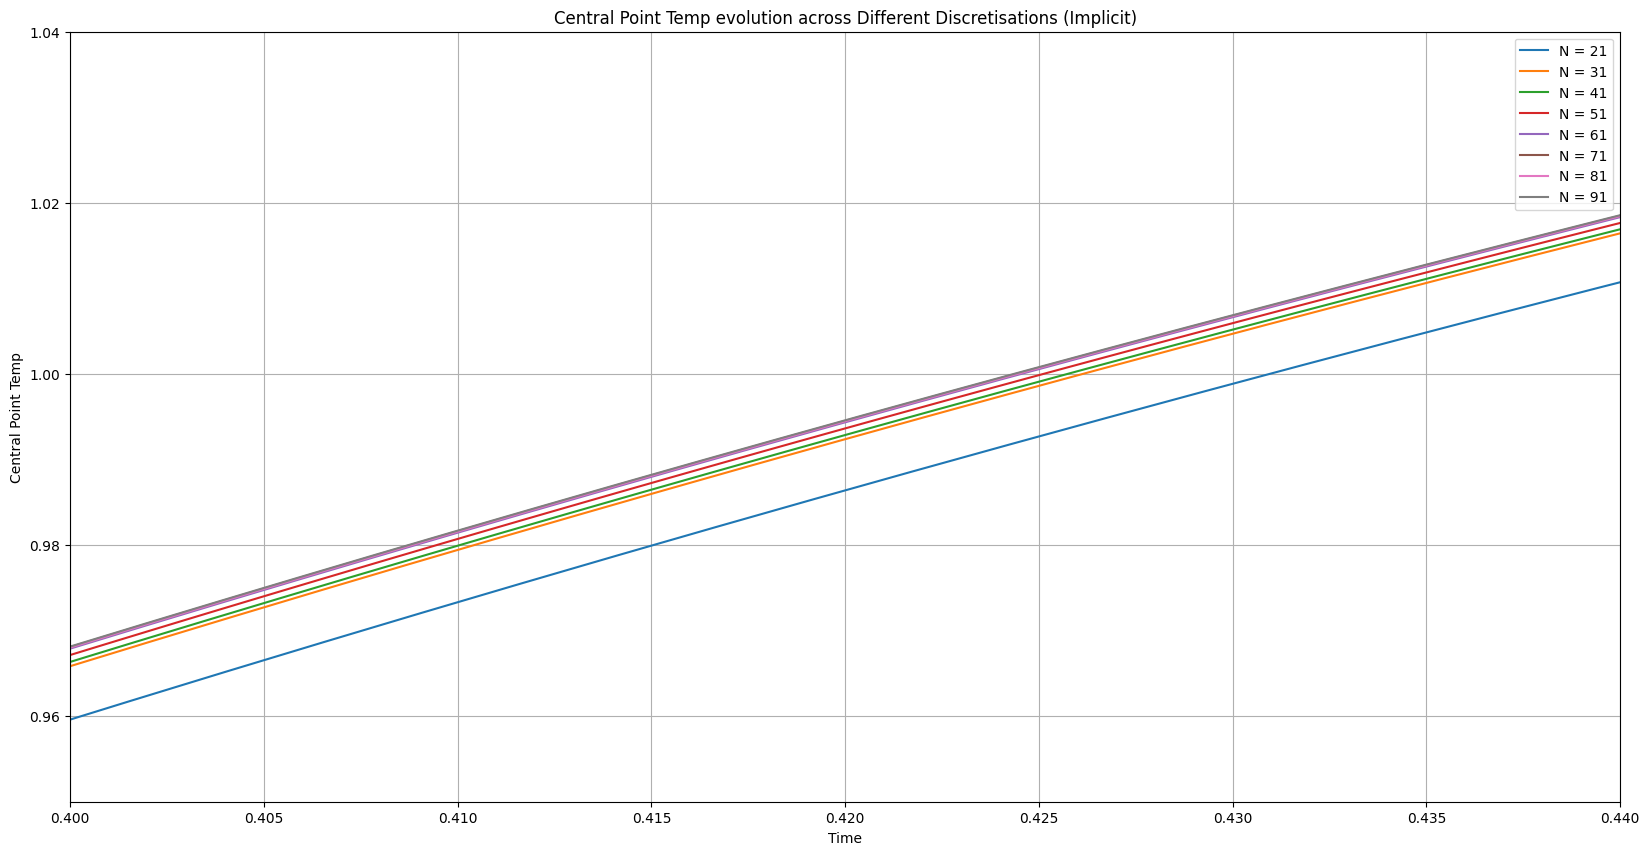

In [74]:
plt.figure(figsize=(20,10))
plt.title('Central Point Temp evolution across Different Discretisations (Implicit)')
plt.xlabel('Time')
plt.ylabel('Central Point Temp')
for i in range(len(central_temps_back)):
    plt.plot(np.linspace(0,0.5,len(central_temps_back[i])),central_temps_back[i],label=f'N = {np.arange(21,101,10)[i]}')
plt.legend(loc='best')
plt.grid()

plt.figure(figsize=(20,10))
plt.title('Central Point Temp evolution across Different Discretisations (Implicit)')
plt.xlabel('Time')
plt.ylabel('Central Point Temp')
for i in range(len(central_temps_back)):
    plt.plot(np.linspace(0,0.5,len(central_temps_back[i])),central_temps_back[i],label=f'N = {np.arange(21,101,10)[i]}')
plt.xlim(left = 0.4,right = 0.44)
plt.ylim(top = 1.04,bottom = 0.95)
plt.legend(loc='best')
plt.grid()

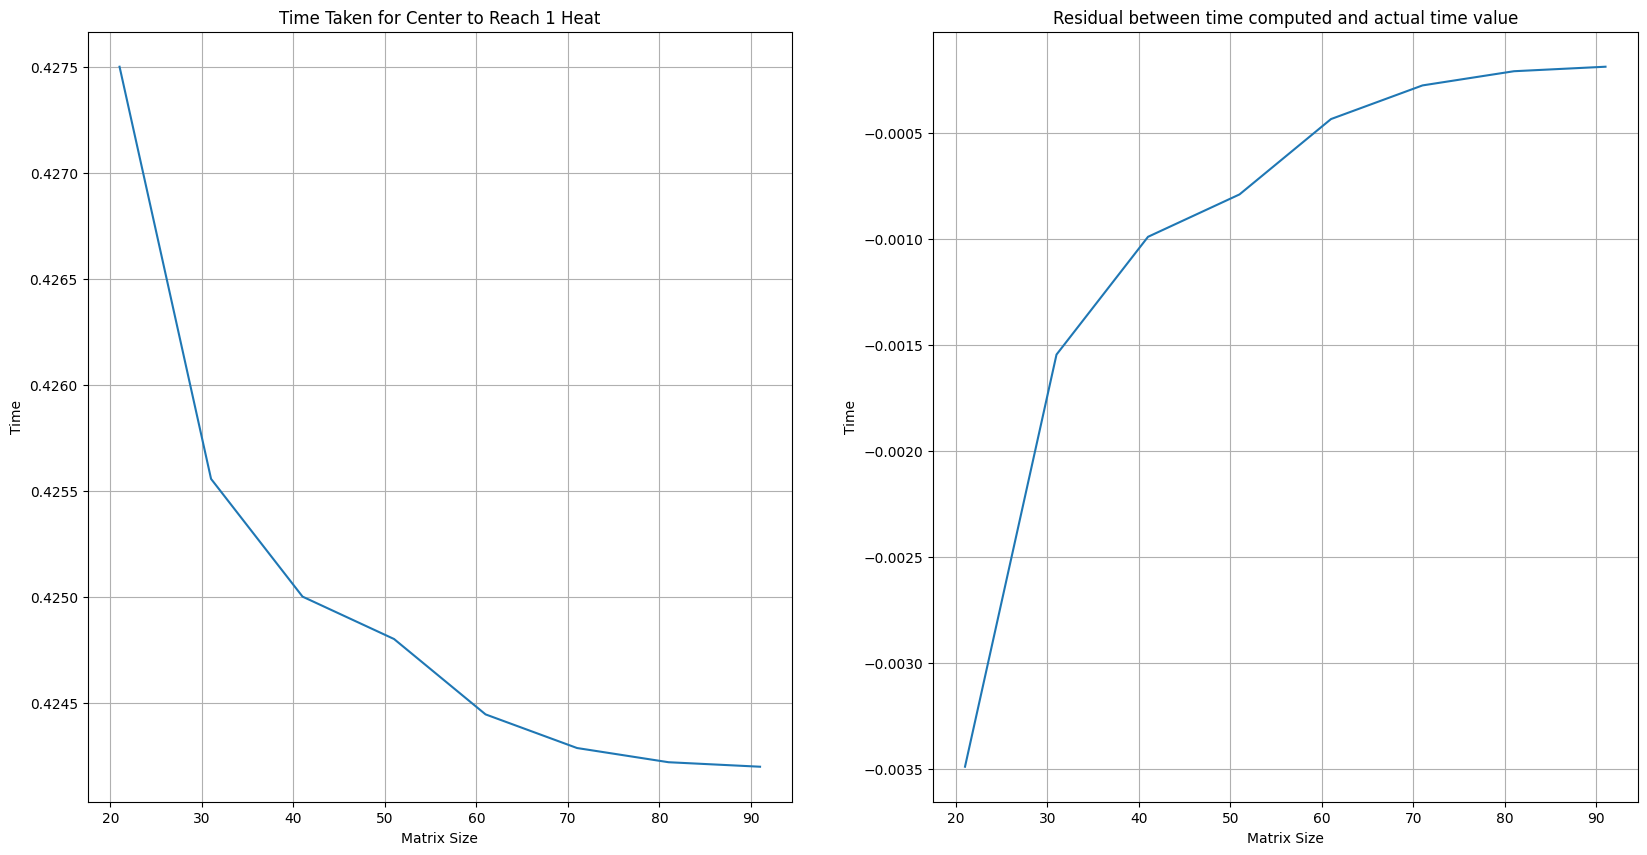

In [66]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
ax1.plot(np.arange(21,101,10),times_back_)
ax1.set_title('Time Taken for Center to Reach 1 Heat')
ax1.set_xlabel('Matrix Size')
ax1.set_ylabel('Time')
ax2.set_ylabel('Time')
ax2.set_xlabel('Matrix Size')
ax2.plot(np.arange(21,101,10),0.424011387033-np.array(times_back_))
ax2.set_title('Residual between time computed and actual time value')
ax1.grid(True)
ax2.grid(True)

It can be seen above that the implicit scheme overestimates the time taken for the central point to heat to 1 when the number of discretisation points N is small. This is because at lower discretisation points the heat transfer is underestimated in the implicit scheme as opposed to it being overestimated in the explicit scheme. The stability benefits that the implicit approach can offer is outweighed by the extremely slow execution time means that it is optimal for small values of N.

### Explicit vs Implicit Timestepping Convergance

Below I will plot the convergance of the time taken for the central point on the plate to reach a heat of 1 using the explicit and implicit time stepping techniques. I will compare them by plotting them on the same graph. I will first plot the actual error and then I will plot the relative absolute error. The explicit time stepping scheme tested will be the CPU version.

In [84]:
times_forward_, central_temps_forward = time_central_val(np.arange(21,101,10),func = forward_euler_cpu_efficient)

100%|██████████| 8/8 [00:00<00:00,  8.14it/s]


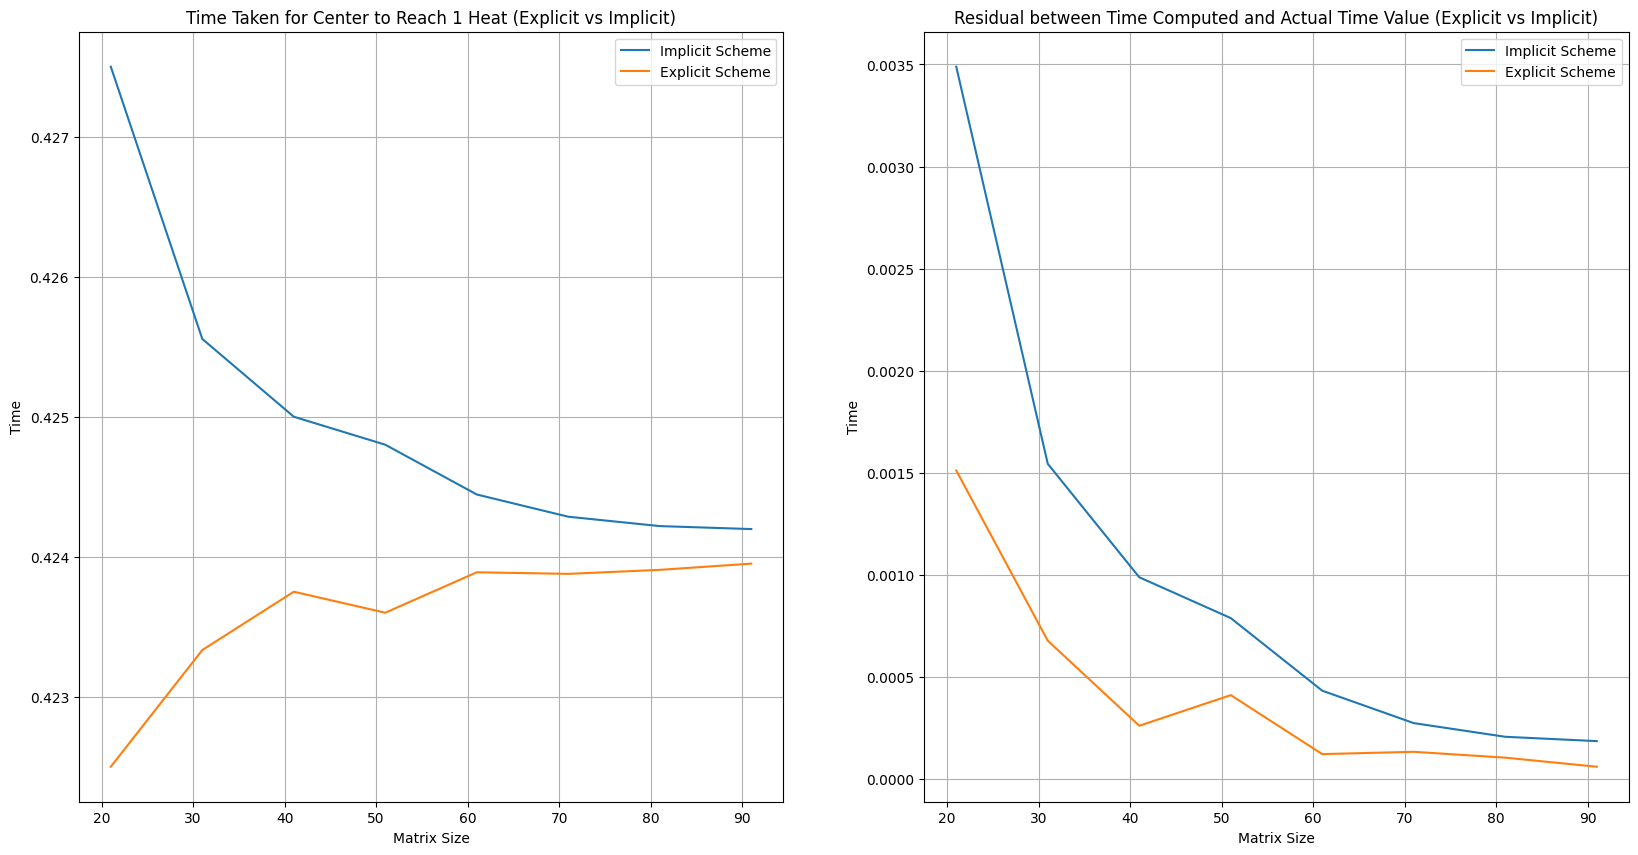

In [86]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
ax1.plot(np.arange(21,101,10),times_back_,label='Implicit Scheme')
ax1.plot(np.arange(21,101,10),times_forward_,label='Explicit Scheme')
ax1.set_title('Time Taken for Center to Reach 1 Heat (Explicit vs Implicit)')
ax1.set_xlabel('Matrix Size')
ax1.set_ylabel('Time')
ax1.legend(loc = 'best')
ax2.set_ylabel('Time')
ax2.set_xlabel('Matrix Size')
ax2.plot(np.arange(21,101,10),abs(0.424011387033-np.array(times_back_)),label='Implicit Scheme')
ax2.plot(np.arange(21,101,10),abs(0.424011387033-np.array(times_forward_)),label='Explicit Scheme')
ax2.set_title('Residual between Time Computed and Actual Time Value (Explicit vs Implicit)')
ax2.legend(loc='best')
ax1.grid(True)
ax2.grid(True)

# Stability Investigation
## Explicit Timestepping for Forward Euler Stability requirements

The stability of the Explicit timestepping technique depends on the criteria that $C \le \frac{\Delta t}{(\Delta x)^2}$ where C is the courant number. In my code I use C to represent the ratio between the distance step squared and the time step and I will vary it while observing the stability of the system. From the literature I assume this ratio to be 0.25 but I will test this by testing values above and below this for the explicit timestepping approach. I will use an N value of 51. Below it can be seen that a lower Courant number or to be more accurate the lower the ratio $\frac{\Delta t}{(\Delta x)^2}$, the more accurate the solution. It can also be seen that when this ratio exceeds 0.25 the system looses all stability. This can be seen numerically through the visual representation of the plate with nonensical values in the grid such as negative numbers and an incoherent heat propogation path/gradient.$

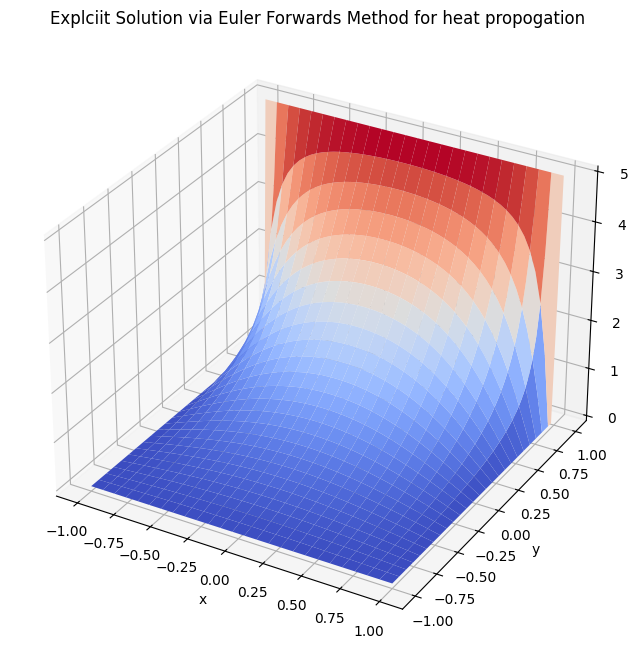

The time at which the central temperature reaches 1 in this implementation is: 0.42400000000004445


In [120]:
O,_,count = forward_euler_cpu_efficient(51,max_time=0.5,C = 0.05)
fig = plt.figure(figsize=(8, 8)) 
#Define the type of figure
ax = fig.add_subplot(projection='3d') 
#Create axes
ticks= np.linspace(-1, 1, O.shape[1]) 
X, Y = np.meshgrid(ticks, ticks) 
#Define surface
surf = ax.plot_surface(X, Y, O[1], 
                       antialiased=True, cmap=cm.coolwarm) 
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y)')
ax.set_title('Explciit Solution via Euler Forwards Method for heat propogation')
plt.show()
print("The time at which the central temperature reaches 1 in this implementation is:",count)

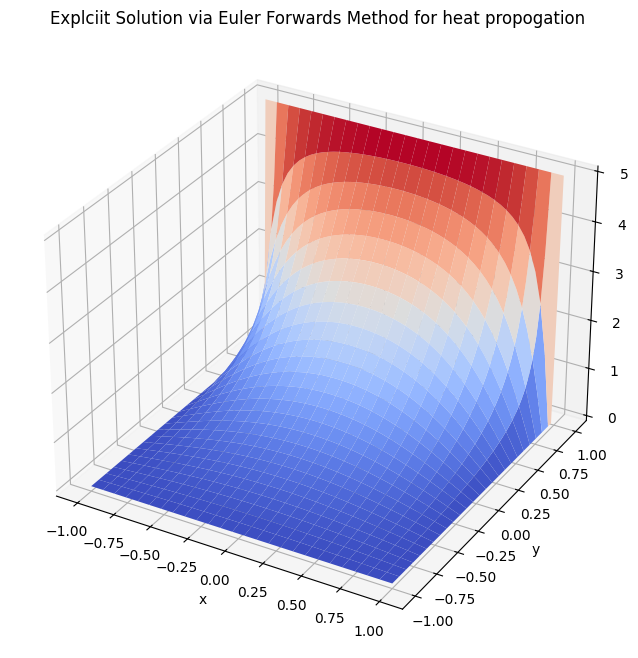

The time at which the central temperature reaches 1 in this implementation is: 0.423600000000008


In [121]:
O,_,count = forward_euler_cpu_efficient(51,max_time=0.5,C = 0.25)
fig = plt.figure(figsize=(8, 8)) 
#Define the type of figure
ax = fig.add_subplot(projection='3d') 
#Create axes
ticks= np.linspace(-1, 1, O.shape[1]) 
X, Y = np.meshgrid(ticks, ticks) 
#Define surface
surf = ax.plot_surface(X, Y, O[1], 
                       antialiased=True, cmap=cm.coolwarm) 
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y)')
ax.set_title('Explciit Solution via Euler Forwards Method for heat propogation')
plt.show()
print("The time at which the central temperature reaches 1 in this implementation is:",count)

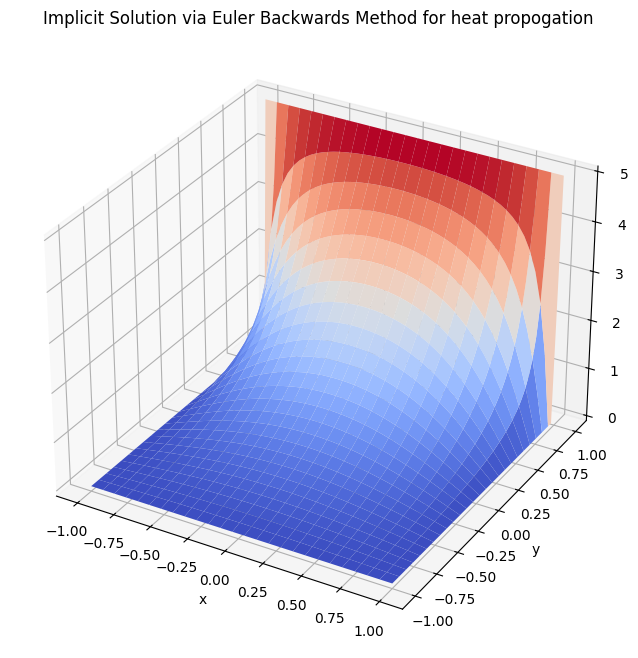

The time at which the central temperature reaches 1 in this implementation is: 0.4238400000000087


In [101]:
O,_,count = forward_euler_cpu_efficient(51,max_time=0.5,C = 0.15)
fig = plt.figure(figsize=(8, 8)) 
#Define the type of figure
ax = fig.add_subplot(projection='3d') 
#Create axes
ticks= np.linspace(-1, 1, O.shape[1]) 
X, Y = np.meshgrid(ticks, ticks) 
#Define surface
surf = ax.plot_surface(X, Y, O[1], 
                       antialiased=True, cmap=cm.coolwarm) 
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y)')
ax.set_title('Implicit Solution via Euler Backwards Method for heat propogation')
plt.show()
print("The time at which the central temperature reaches 1 in this implementation is:",count)

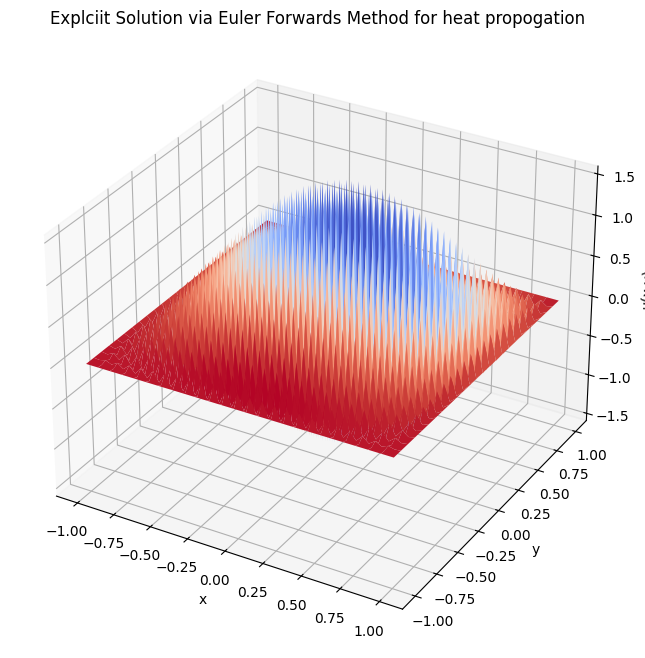

The time at which the central temperature reaches 1 in this implementation is: 0.2665600000000017


In [122]:
O,_,count = forward_euler_cpu_efficient(51,max_time=0.5,C = 0.35)
fig = plt.figure(figsize=(8, 8)) 
#Define the type of figure
ax = fig.add_subplot(projection='3d') 
#Create axes
ticks= np.linspace(-1, 1, O.shape[1]) 
X, Y = np.meshgrid(ticks, ticks) 
#Define surface
surf = ax.plot_surface(X, Y, O[1], 
                       antialiased=True, cmap=cm.coolwarm) 
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y)')
ax.set_title('Explciit Solution via Euler Forwards Method for heat propogation')
plt.show()
print("The time at which the central temperature reaches 1 in this implementation is:",count)

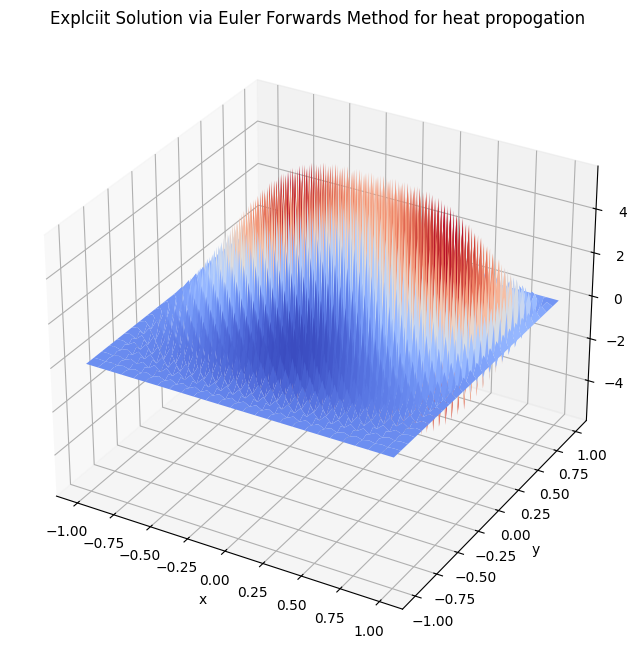

The time at which the central temperature reaches 1 in this implementation is: 0.2695999999999995


In [123]:
O,_,count = forward_euler_cpu_efficient(51,max_time=0.5,C = 0.5)
fig = plt.figure(figsize=(8, 8)) 
#Define the type of figure
ax = fig.add_subplot(projection='3d') 
#Create axes
ticks= np.linspace(-1, 1, O.shape[1]) 
X, Y = np.meshgrid(ticks, ticks) 
#Define surface
surf = ax.plot_surface(X, Y, O[1], 
                       antialiased=True, cmap=cm.coolwarm) 
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y)')
ax.set_title('Explciit Solution via Euler Forwards Method for heat propogation')
plt.show()
print("The time at which the central temperature reaches 1 in this implementation is:",count)

### Implicit Timestepping

The stability of the implicit timestepping technique depends on the requirement that the matrix A has all negative eigenvalues. The backwards difference technique for this specific example is unconditionally stable as shown below when the Courant number is varied. I will vary the courant number when N = 51 and analyse the accuracy of the solution. A higher Courant number also should reduce the computational time required to converge on the solution as the timestep dt would be larger although accuracy may be reduced due to larger steps being taken. It can be seen that uunlike the explicit time stepping, when the Courant number is set to higher values that although the accuracy of the solution decreases, the system remains stable and produces a coherent heat propogation model showing the plate's final state. It can be seen that the lower the courant number the more accurate the solution is although it remains accurate to three decimal places for the most part.

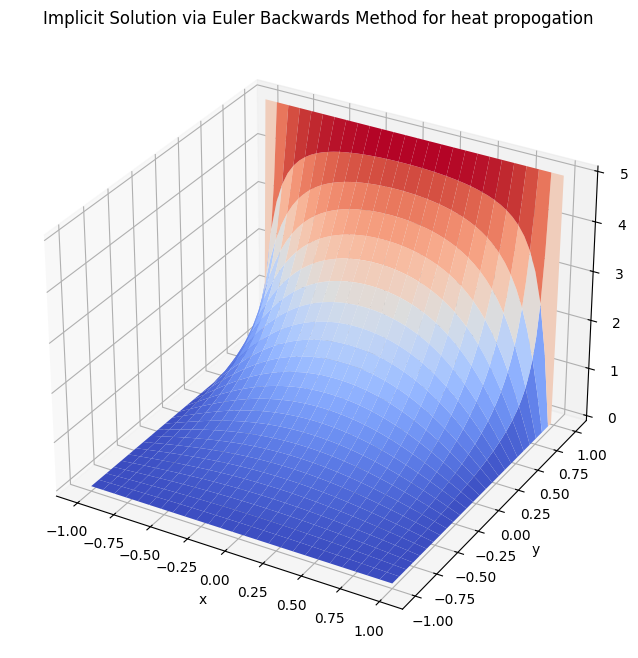

The time at which the central temperature reaches 1 in this implementation is: 0.42480000000000806


In [99]:
O,_,count = backwards_euler(51,max_time=0.5,C = 0.25)
O = O.reshape(51,51)
fig = plt.figure(figsize=(8, 8)) 
#Define the type of figure
ax = fig.add_subplot(projection='3d') 
#Create axes
ticks= np.linspace(-1, 1, O.shape[0]) 
X, Y = np.meshgrid(ticks, ticks) 
#Define surface
surf = ax.plot_surface(X, Y, O, 
                       antialiased=True, cmap=cm.coolwarm) 
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y)')
ax.set_title('Implicit Solution via Euler Backwards Method for heat propogation')
plt.show()
print("The time at which the central temperature reaches 1 in this implementation is:",count)

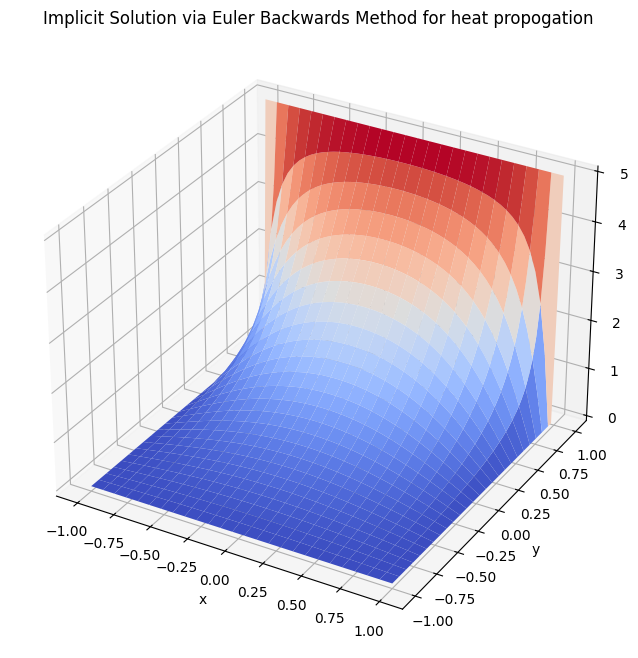

The time at which the central temperature reaches 1 in this implementation is: 0.4241600000000445


In [100]:
O,_,count = backwards_euler(51,max_time=0.5,C = 0.05)
O = O.reshape(51,51)
fig = plt.figure(figsize=(8, 8)) 
#Define the type of figure
ax = fig.add_subplot(projection='3d') 
#Create axes
ticks= np.linspace(-1, 1, O.shape[0]) 
X, Y = np.meshgrid(ticks, ticks) 
#Define surface
surf = ax.plot_surface(X, Y, O, 
                       antialiased=True, cmap=cm.coolwarm) 
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y)')
ax.set_title('Implicit Solution via Euler Backwards Method for heat propogation')
plt.show()
print("The time at which the central temperature reaches 1 in this implementation is:",count)

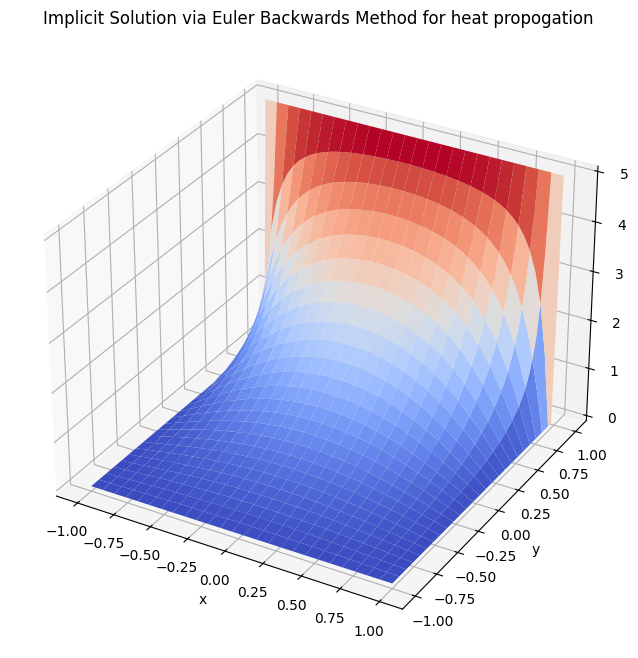

The time at which the central temperature reaches 1 in this implementation is: 0.42432000000000875


In [96]:
O,_,count = backwards_euler(51,max_time=0.5,C = 0.15)
O = O.reshape(51,51)
fig = plt.figure(figsize=(8, 8)) 
#Define the type of figure
ax = fig.add_subplot(projection='3d') 
#Create axes
ticks= np.linspace(-1, 1, O.shape[0]) 
X, Y = np.meshgrid(ticks, ticks) 
#Define surface
surf = ax.plot_surface(X, Y, O, 
                       antialiased=True, cmap=cm.coolwarm) 
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y)')
ax.set_title('Implicit Solution via Euler Backwards Method for heat propogation')
plt.show()
print("The time at which the central temperature reaches 1 in this implementation is:",count)

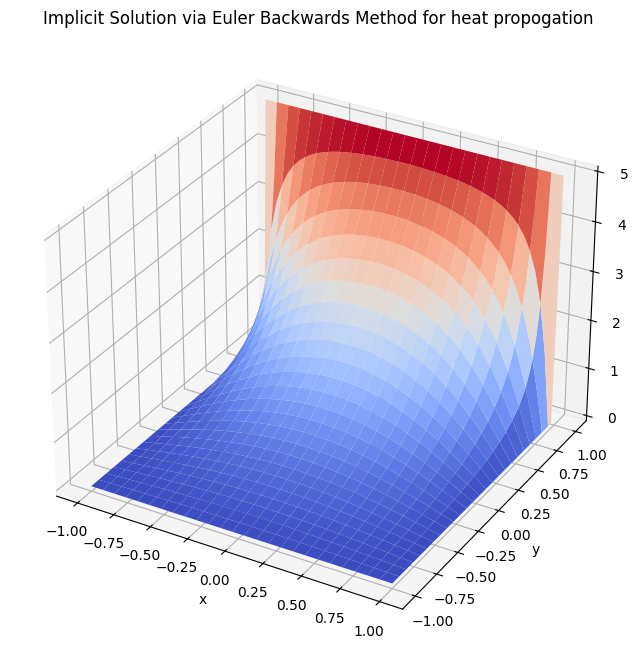

The time at which the central temperature reaches 1 in this implementation is: 0.4250400000000031


In [97]:
O,_,count = backwards_euler(51,max_time=0.5,C = 0.35)
O = O.reshape(51,51)
fig = plt.figure(figsize=(8, 8)) 
#Define the type of figure
ax = fig.add_subplot(projection='3d') 
#Create axes
ticks= np.linspace(-1, 1, O.shape[0]) 
X, Y = np.meshgrid(ticks, ticks) 
#Define surface
surf = ax.plot_surface(X, Y, O, 
                       antialiased=True, cmap=cm.coolwarm) 
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y)')
ax.set_title('Implicit Solution via Euler Backwards Method for heat propogation')
plt.show()
print("The time at which the central temperature reaches 1 in this implementation is:",count)

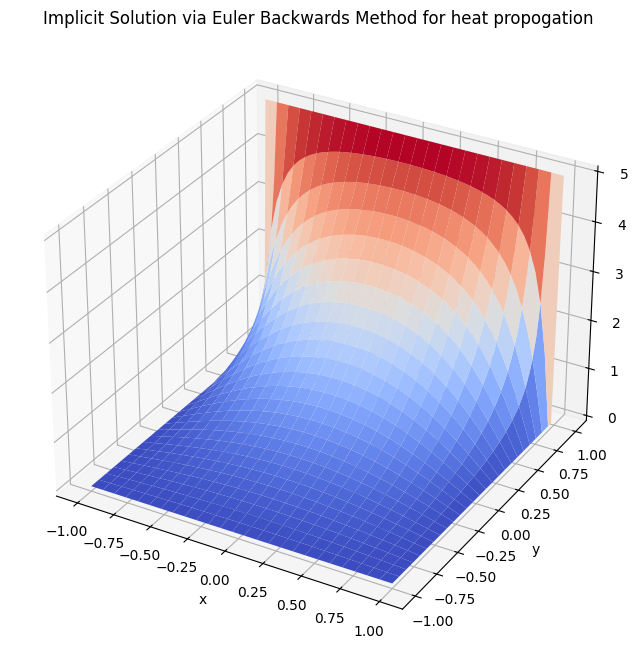

The time at which the central temperature reaches 1 in this implementation is: 0.425600000000004


In [98]:
O,_,count = backwards_euler(51,max_time=0.5,C = 0.5)
O = O.reshape(51,51)
fig = plt.figure(figsize=(8, 8)) 
#Define the type of figure
ax = fig.add_subplot(projection='3d') 
#Create axes
ticks= np.linspace(-1, 1, O.shape[0]) 
X, Y = np.meshgrid(ticks, ticks) 
#Define surface
surf = ax.plot_surface(X, Y, O, 
                       antialiased=True, cmap=cm.coolwarm) 
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y)')
ax.set_title('Implicit Solution via Euler Backwards Method for heat propogation')
plt.show()
print("The time at which the central temperature reaches 1 in this implementation is:",count)

## Conclusion:

I have implemented both the forward and backward euler timestepping schemes to model heat propogation of a plate split into N by N discretisation points. I have implemented a version of the explicit timestepping scheme that uses the CPU and stores all the timesteps of the plate in one three dimensional matrix, I have implemented a more memory efficient version that stores two heat slices at a time and I have implemented a version that uses GPU computing to accelerate the process at the cost of reduced stability as the grid size increases. The maximum accuracy that was reached was using the CPU numba accelerated forward euler time stepping scheme that resulted in 5 to 6 digits of precision when the grid size reached 1000 data points. This however took 1 hour and a half and was substantially slower than the GPU equivalent which although calculated the steps more slowly had a small introduction of error due to how operations are processed in the CUDA architecture. The implicit timestepping technique was investigated and found to have complete stability at different $\frac{\Delta t}{(\Delta x)^2}$ ratios as opposed to the explicit method which broke down when the ratio exceeded the courant number for a 2D system C = 0.25. The implicit scheme also converged much more steadily to the correct solution whilst the explicit methods were more accurate but more volatile. It seems that for precise and accurate solutions the explicit method is unconditionally better however potential uses of the implicit solution could be if we are working with a highly granular grid but want the timestep to increase so that the $\frac{\Delta t}{(\Delta x)^2}$ is much larger than the Courant number C. This could mean that in the long run due to the reduced timesteps the implcit solution could be a wildly inaccurate but quicker approximation of heat transfer. Due to limited time and teh extrememly long run time of these schemes I was not able to experiment with higher N values and lower C ratios to achieve the highest possible precisions. Given more computing power however if the C ratio was extremely small and the N value was extremely high potentially 12 digits of precision could be reached.

##### Explicit Scheme utilising matrix vector operations:

The explicit euler forwards timestepping scheme can further be improved if instead of applying the recursion equation shown above to the individual elements as done above the iterative expression is expressed as an operator that can be recursively multiplied by a representation of the heat on the plate. This was not implemented as the pre existing forward euler methods are suitable but a potential method of doing this utilising sparse matrix data structures is shown below.

In [ ]:
"""
def discretise_explicit(N,C,alpha):

    #define parameters
    nelements = 5 * N**2 - 16 * N + 16
    row_ind = np.empty(nelements, dtype=np.float64) 
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    count = 0
    for j in range(N):
        for i in range(N):
            #treating boundary cases
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                #Boundaries are diagonal and preserved by I
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                count += 1
            else:
                #Iterate one row at a time
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = alpha
                data[count + 1 : count + 5] = C
                
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)),shape=(N**2, N**2)).tocsr()


def matvec_explicit(N,C = 0.25, max_time = 0.5):
    assert N%2 != 0, "Please Input an Odd number of discretisation points."
    dx = 2/(N-1)
    dt = C * dx**2
    iterations = int(max_time//dt)
    alpha = 1 - 4*C
    SX = 512
    SY = 4*(N-1)+5*(N-2)**2
    nblocks = (N**2 + SX -1) // SX
    u = np.zeros(N**2)
    U = np.zeros(N**2)
    u.reshape(N,N)[-1,:] = 5
    A = discretise_explicit(N,C,alpha)

    @cuda.jit
    def GPU_2(N_R, data , indices, indptr, u_gpu, U_gpu):
        #Define local and global thread locations 
        tx = cuda.threadIdx.x
        bx = cuda.blockIdx.x
        row = SX * bx + tx
        cuda.syncthreads()
        #Remain in bounds
        if row < N_R:
            temp = 0.
            cs = indptr[row]
            ce = indptr[row+1]
            #For each row evaluate the linear system on only the none zero columns
            for c in range(cs,ce):
                temp += data[c] * u_gpu[indices[c]]
            #Save data locally
            U_gpu[row] = temp 
            cuda.syncthreads()
    U_gpu = cuda.to_device(U)
    u_gpu = cuda.to_device(u)
    timer = 0
    midtemps = []
    data_gpu,indices_gpu,indptr_gpu = cuda.to_device(A.data),cuda.to_device(A.indices),cuda.to_device(A.indptr)
    for i in range(iterations):
        GPU_2[(nblocks,1),(SX,1)](u.shape[0],data_gpu,indices_gpu,indptr_gpu,u_gpu,U_gpu)
        mid_temp = u_gpu[N//2 * N + N//2]
        midtemps.append(mid_temp)
        if mid_temp < 1:
            timer += dt
        u_gpu = U_gpu
    u_gpu.copy_to_host(u)
    return u,midtemps, timer
"""